# Ross Sea synthetic gravity inversion

Here we try to recover the true bathymetry with a gravity inversion for a portion of the Ross Sea. We create a synthetic gravity dataset which is the forward gravity of 3 density contrasts across real topographic surfaces. The first is the air-water surface, from BedMap2. The second is the water-sediment (bathymetry) surface, also from BedMap2. The third is the sediment-basement, from the ANTOSTRAT seismic surveys. We use three version of this synthetic observed gravity; 1) a "perfect" gravity survey at a constant 1000m above sea level, which stations evenly spacing in a 2km grid over the region, with and without 2% gaussian noise added, 2) a resampled gravity survey at 10km spacing, with and with 2% noise, and 3) a synthetic airborne survey, with N-S and E-W flight lines at a constant 1000m altitude, with several gaps between lines. We create a low-resolution bathymetry by samping the true bathymetry at 110 random "constraint" points, and regridding the surface with just these values. In an Antarctic setting, these points represent single seismic survey locations which image the bathymetry surface.

All of these processes are included in the notebook `Ross_Sea_synthetic_model.ipynb`.  While not included as a layer in the inversion, the forward gravity of the basement is included in the observed gravity. This field represents the regional gravity signal from factors such as long wavelength crustal thickness variations. 

import packages

In [2]:
%load_ext autoreload
%autoreload 2
%load_ext snakeviz

import sys

sys.path.insert(1, "../")

import RIS_gravity_inversion.inversion as inv
import RIS_gravity_inversion.plotting as plots
import RIS_gravity_inversion.utils as inv_utils
import RIS_gravity_inversion.synthetic as synth 
import RIS_gravity_inversion.optimization as opti 

from antarctic_plots import utils, regions, maps, fetch, profile
import zarr
import harmonica as hm
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import verde as vd
import scipy as sp
import pvxarray
import rioxarray
import pygmt
import plotly.graph_objects as go
import optuna
from optuna.storages import JournalStorage, JournalFileStorage
import warnings
import itertools

import os

# Load data

## topographic layers
* 2 full resolution layers 
* low resolution bed

In [3]:
surface = xr.open_zarr("../synthetic_data/Ross_Sea_surface.zarr").z

bed = xr.open_zarr("../synthetic_data/Ross_Sea_bed.zarr").z

lowres_bed = xr.open_zarr("../synthetic_data/Ross_Sea_lowres_bed.zarr").z

print(utils.get_grid_info(surface))
print(utils.get_grid_info(bed))
print(utils.get_grid_info(lowres_bed))
lowres_bed

/home/tankerma/miniconda/envs/RIS_gravity_inversion/lib/python3.9/site-packages/xarray/backends/plugins.py:71: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


(5000.0, [-300000.0, 250000.0, -1900000.0, -1500000.0], -65.658416748, -55.9449195862, 'g')
(5000.0, [-300000.0, 250000.0, -1900000.0, -1500000.0], -4115.15136719, -267.01361084, 'g')
(5000.0, [-300000.0, 250000.0, -1900000.0, -1500000.0], -3885.21142578, -305.317504883, 'g')


<xarray.DataArray 'z' (northing: 81, easting: 111)>
dask.array<open_dataset-cab6cf74e0c5c70e6704bf187ccc4ad7z, shape=(81, 111), dtype=float32, chunksize=(81, 111), chunktype=numpy.ndarray>
Coordinates:
  * easting   (easting) float64 -3e+05 -2.95e+05 -2.9e+05 ... 2.45e+05 2.5e+05
  * northing  (northing) float64 -1.9e+06 -1.895e+06 ... -1.505e+06 -1.5e+06
Attributes:
    actual_range:  [-3885.21142578125, -305.3175048828125]
    long_name:     z

## gravity data
* full resolution gravity data
* 10km resampled gravity data
* airborne survey gravity data

* full resolution forward gravity of the regional field (basement)

In [4]:
# true regional gravity anomaly
true_regional_grav = xr.open_zarr("../synthetic_data/Ross_Sea_forward_grav.zarr").basement

# full resolution gravity point data
full_res_grav = pd.read_csv(
    "../synthetic_data/Ross_Sea_full_res_gravity.csv.gz",
    sep=",",
    header="infer",
    index_col=None,
    compression="gzip",
)

# sampled gravity point data
sampled_grav = pd.read_csv(
    "../synthetic_data/Ross_Sea_sampled_gravity.csv.gz",
    sep=",",
    header="infer",
    index_col=None,
    compression="gzip",
)

# airborne survey gravity point data
airborne_survey_grav = pd.read_csv(
    "../synthetic_data/Ross_Sea_airborne_survey_gravity.csv.gz",
    sep=",",
    header="infer",
    index_col=None,
    compression="gzip",
)

# Set region and parameters

Use the same regions and parameters as `Ross_Sea synthetic_model.ipynb`

In [5]:
layer_spacing, inversion_region, _, _, registration = utils.get_grid_info(bed)

# set gravity observation parameters
grav_observation_height = 1e3
sampled_grav_spacing = 20e3
airborne_grav_spacing = 1e3

buffer_region = utils.alter_region(
    inversion_region,
    buffer=0,
)[1]

print(f"layer spacing: {layer_spacing}m")
print(f"registration: {registration}")
print("inversion region = ", inversion_region)
print("buffer region = ", buffer_region)

layer spacing: 5000.0m
registration: g
inversion region =  [-300000.0, 250000.0, -1900000.0, -1500000.0]
buffer region =  [-300000, 250000, -1900000, -1500000]


### prep grav data

In [6]:
full_res_grav = inv_utils.prep_grav_data(
    full_res_grav,
    region=inversion_region,
    input_grav_name="forward_total",
    input_coord_names=("easting","northing","upward"), 
)

sampled_grav = inv_utils.prep_grav_data(
    sampled_grav,
    region=inversion_region,
    input_grav_name="Gobs",
    input_coord_names=("easting","northing","upward"), 
)

airborne_survey_grav = inv_utils.prep_grav_data(
    airborne_survey_grav,
    region=inversion_region,
    input_grav_name="Gobs",
    input_coord_names=("easting","northing","upward"), 
)
print(f"full resolution gravity: {len(full_res_grav)} points")
print(f"sampled gravity: {len(sampled_grav)} points")
print(f"airborne survey gravity: {len(airborne_survey_grav)} points")

print(f"gravity avg. elevation: {int(np.nanmean(full_res_grav.upward))}")

full resolution gravity: 8991 points
sampled gravity: 609 points
airborne survey gravity: 16800 points
gravity avg. elevation: 1000


## constraint points

In [7]:
# load constraint points into a dataframe
constraint_points_all = pd.read_csv(
    "../synthetic_data/Ross_Sea_synthetic_constraints.csv.gz",
    sep=",",
    header="infer",
    index_col=None,
    compression="gzip",
)

# ensure all points are within inversion region
constraint_points = utils.points_inside_region(
    constraint_points_all,
    inversion_region,
    names = ("easting", "northing")
)

# set conventional names
print(f"bathymetry control points:{len(constraint_points)}")
constraint_points.head()

bathymetry control points:110


easting      northing       upward
0  -60202.803822 -1.794489e+06  -672.470024
1 -285740.572495 -1.534434e+06 -1704.880401
2    2314.362833 -1.732106e+06  -288.343065
3  -60572.684060 -1.683923e+06  -472.233651
4  -68797.708852 -1.656623e+06  -477.404576

# Full resolution observed gravity

## grid with eq sources
We need gravity data with a spacing similar to the spacing we desire for the topography. To achieve this, we use the equivalent source technique to re-grid the gravity data at a constant spacing and observation height. 

In [25]:
# dampings = np.logspace(-4, 4, num=10)
# depths = np.linspace(1e3, 100e3, 10)

# parameter_sets = [
#     dict(damping=combo[0], depth=combo[1])
#     for combo in itertools.product(dampings, depths)
# ]
# print("Number of combinations:", len(parameter_sets))

In [26]:
# full_res_eq_best, full_res_eq_grid, full_res_eq_df = inv_utils.eq_sources_best(
#     parameter_sets = parameter_sets, 
#     coordinates = (full_res_grav.easting, full_res_grav.northing, full_res_grav.upward), 
#     data = full_res_grav.Gobs, 
#     region = inversion_region, 
#     spacing = layer_spacing, 
#     block_size = layer_spacing*2,
#     depth_type="constant",
# )

# sampled_eq_best, sampled_eq_grid, sampled_eq_df = inv_utils.eq_sources_best(
#     parameter_sets = parameter_sets, 
#     coordinates = (sampled_grav.easting, sampled_grav.northing, sampled_grav.upward), 
#     data = sampled_grav.Gobs, 
#     region = inversion_region, 
#     spacing = layer_spacing, 
#     block_size = layer_spacing*2,
#     depth_type="constant",
# )

# airborne_survey_eq_best, airborne_survey_eq_grid, airborne_survey_eq_df = inv_utils.eq_sources_best(
#     parameter_sets = parameter_sets, 
#     coordinates = (airborne_survey_grav.easting, airborne_survey_grav.northing, airborne_survey_grav.upward), 
#     data = airborne_survey_grav.Gobs, 
#     region = inversion_region, 
#     spacing = layer_spacing, 
#     block_size = layer_spacing*2,
#     depth_type="constant",
# )

In [27]:
# full_res_grav = full_res_eq_df.rename(columns={"predicted_grav":"Gobs"})
# sampled_grav = sampled_eq_df.rename(columns={"predicted_grav":"Gobs"})
# airborne_survey_grav = airborne_survey_eq_df.rename(columns={"predicted_grav":"Gobs"})
# full_res_grav

## Bouguer correction

The `observed gravity` includes a gravitational signal from density contrast of the water surface, the bathymetry, and the basement. Since we want to invert for the bathymetry, we need to remove the components of this gravity from the water surface and the regional field from the basement. Here we show how to remove the water surface component, and later will show how to remove the regional component.

To do this, we build a series of vertical prisms around a flat reference, which we take to be the mean value of the surface. The prisms extend above or below this reference, towards the water surface. Prisms above the reference are assigned a positive density contrast ($\rho_{water}$ - $\rho_{air}$), while prisms below the reference are assigned a negative density contrast ($\rho_{air}$ - $\rho_{water}$). This is shown in b) and c) of the below figure.

At each stage of the inversion, the we ensure the updated bathymetry doesn't intersect the water surface. This means the water surface density contrast will be constant throughout the inversion, and can thus be calculated and accounted for only once, at the beginning. 

Here, we calculate the forward gravity of this density contrast, and remove it from the observed gravity to make a `corrected observed gravity`. 

<img src="../figures/synthetic_model_simple_2layer.svg" width="1000"/>

### Water prisms

In [29]:
# create prisms around Surface
# positive densities above reference, negative below
water_prisms = inv_utils.grids_to_prisms(
    top=surface,
    bottom=surface.values.mean(),
    density=xr.where(surface>=surface.values.mean(), 1030, -1030),
)

# plots.show_prism_layers(
#     [water_prisms],
#     cmap="viridis",
#     color_by="density",
#     # color_by="thickness",
#     zscale=100,
#     clip_box=False,
#     log_scale=False,
# )

### Water gravity

In [30]:
# calculate gravity of layer1
water_grav_grid, water_grav_df = inv_utils.forward_grav_of_prismlayer(
    [water_prisms],
    full_res_grav,
    names=['water_prisms'],
    remove_median=True,
    progressbar=True,
    plot=False,
)

full_res_grav['water_forward'] = water_grav_df.forward_total

# subtract from observed gravity
full_res_grav['Gobs_corr']=full_res_grav.Gobs - full_res_grav.water_forward

# center on 0
full_res_grav['Gobs_corr'] -= full_res_grav['Gobs_corr'].median()

# grid the results
water_forward = full_res_grav.set_index(["northing", "easting"]).to_xarray().water_forward
Gobs_corr = full_res_grav.set_index(["northing", "easting"]).to_xarray().Gobs_corr

# center on 0
water_forward -= np.median(water_forward)
Gobs_corr -= np.median(Gobs_corr)
full_res_grav

  0%|                                                  | 0/8991 [00:00<?, ?it/s]

northing   easting        Gobs  upward  water_forward   Gobs_corr
0    -1900000.0 -300000.0 -110.551061  1000.0      -0.161138 -110.341227
1    -1900000.0 -295000.0 -120.117578  1000.0      -0.174697 -119.894185
2    -1900000.0 -290000.0 -128.074204  1000.0      -0.178454 -127.847054
3    -1900000.0 -285000.0 -132.115085  1000.0      -0.181105 -131.885283
4    -1900000.0 -280000.0 -131.913548  1000.0      -0.183105 -131.681747
...         ...       ...         ...     ...            ...         ...
8986 -1500000.0  230000.0   -1.488473  1000.0       0.134289   -1.574066
8987 -1500000.0  235000.0    0.437614  1000.0       0.132347    0.353963
8988 -1500000.0  240000.0    0.703969  1000.0       0.130925    0.621740
8989 -1500000.0  245000.0   -0.754553  1000.0       0.128878   -0.834735
8990 -1500000.0  250000.0   -2.932893  1000.0       0.118307   -3.002504

[8991 rows x 6 columns]

returning original grid
returning original grid


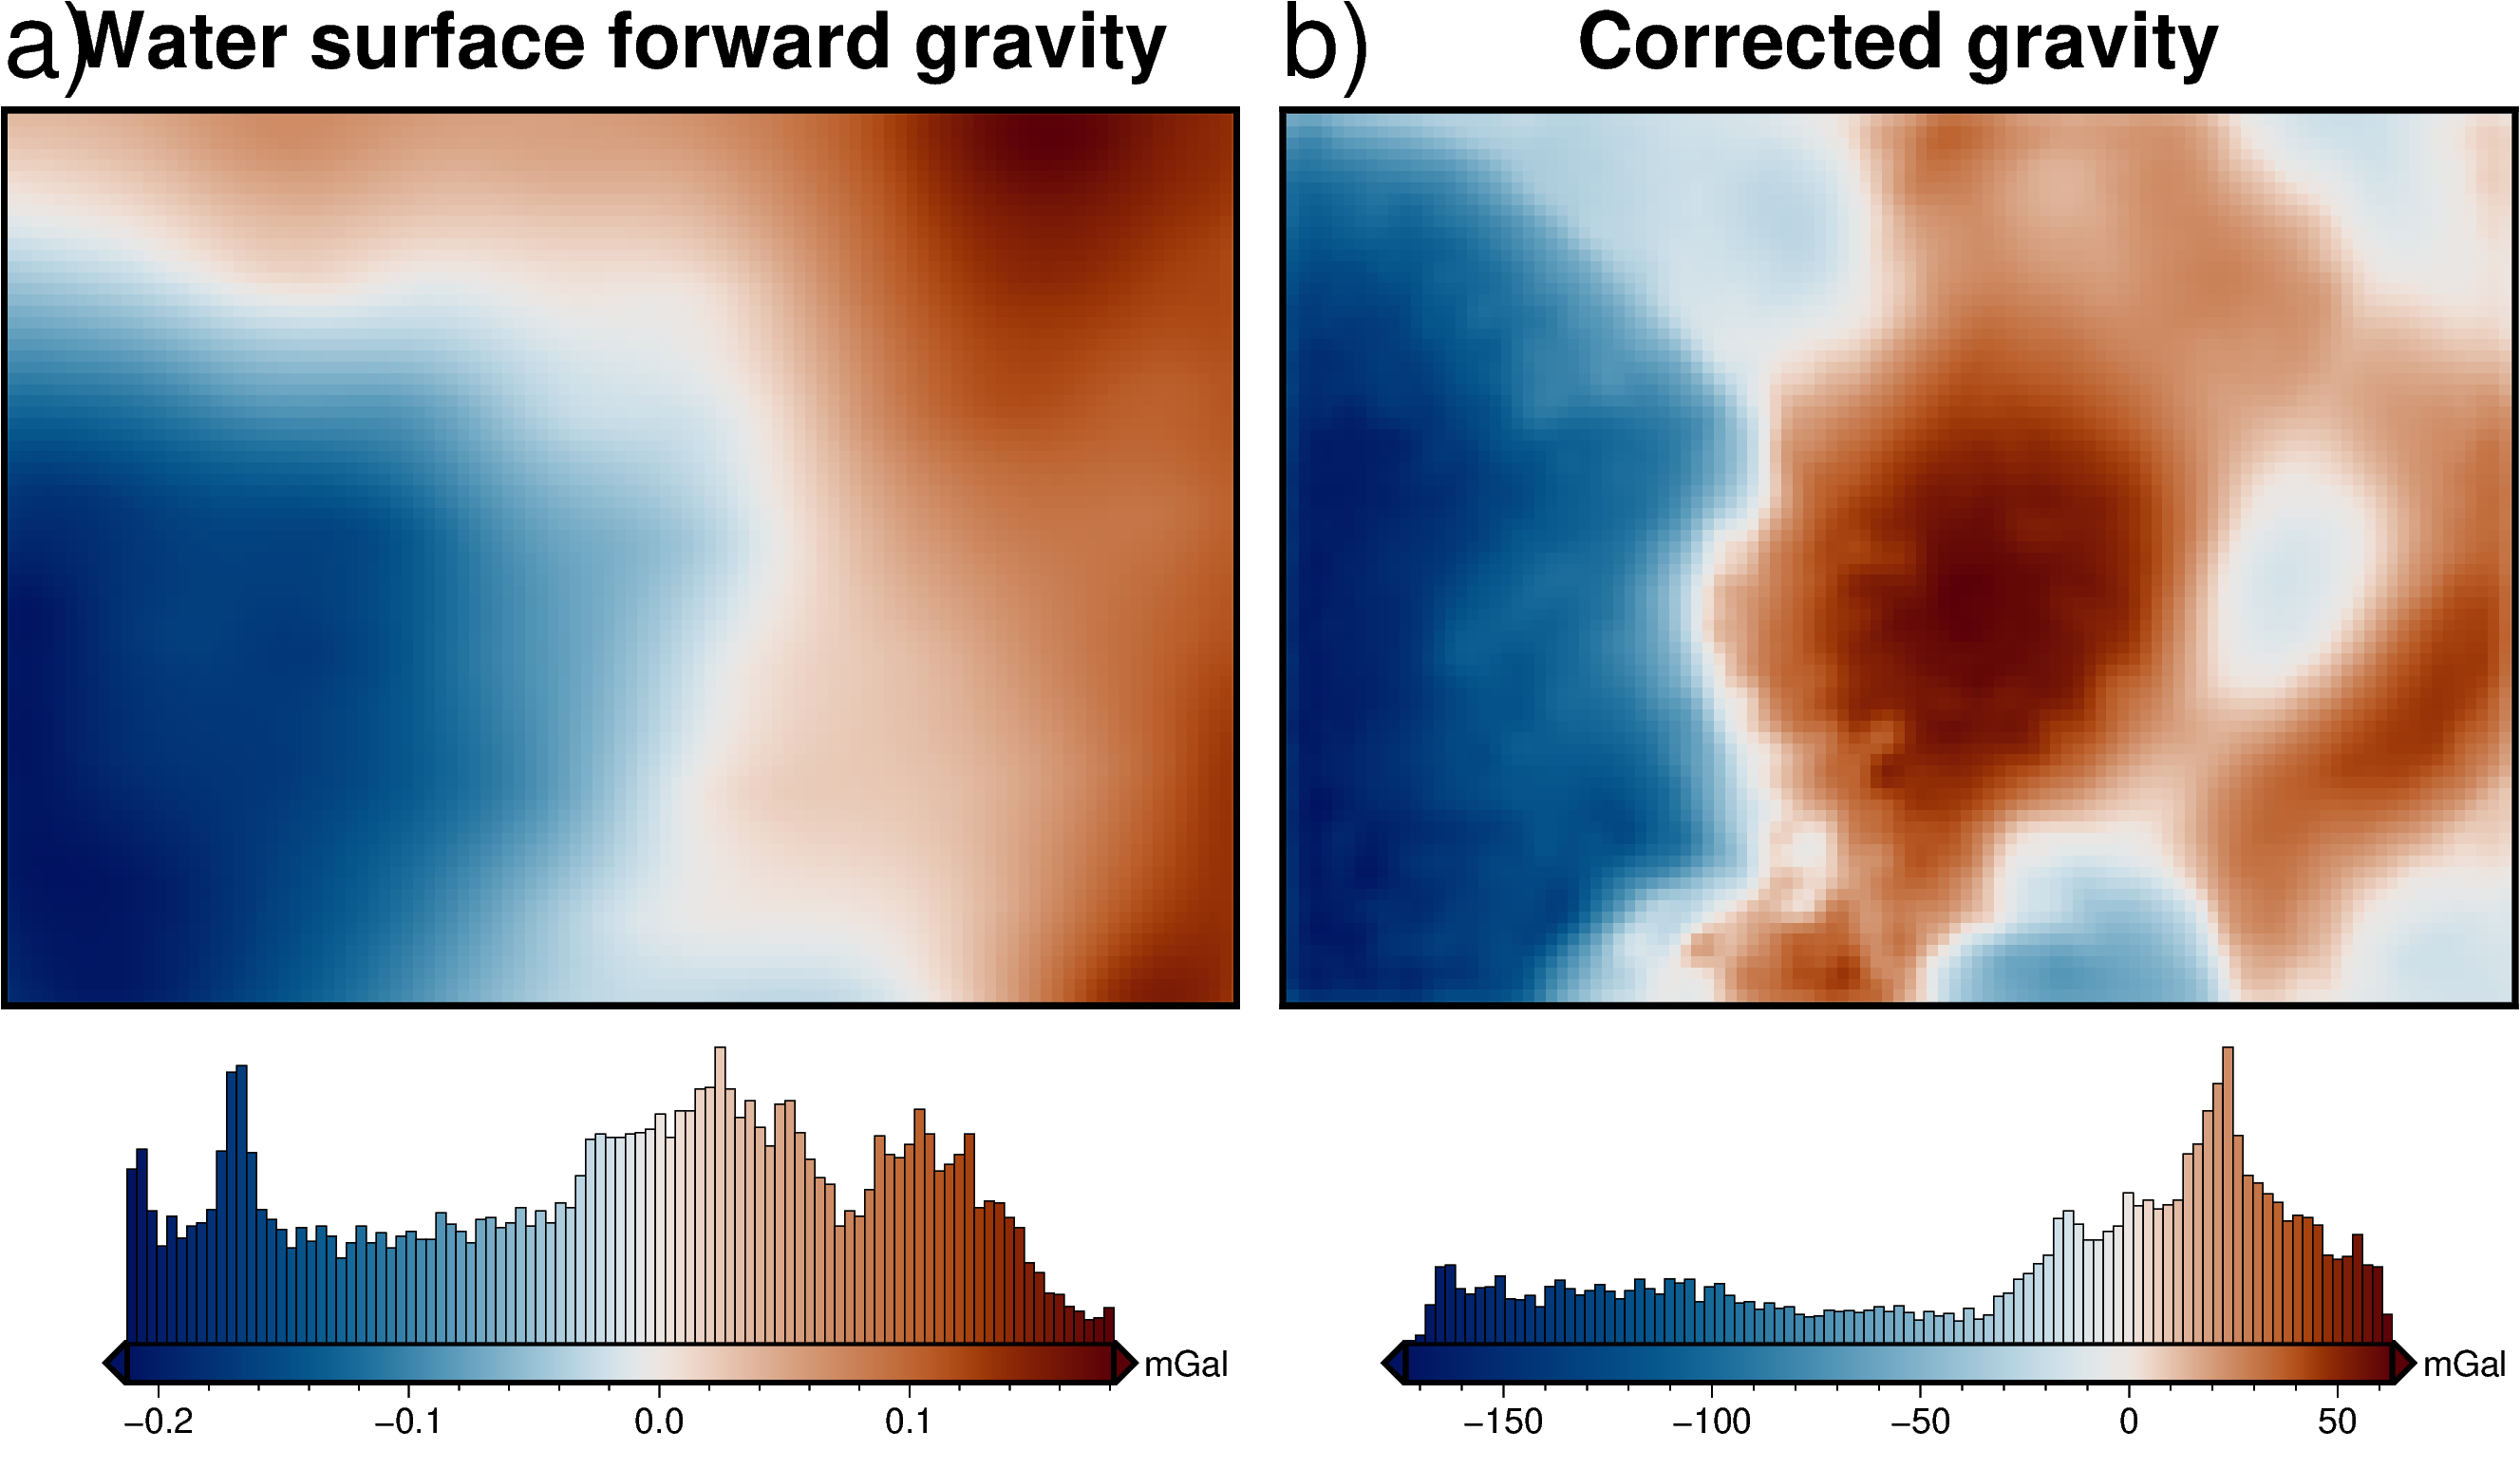

In [31]:
# plot Layer 1 gravity
fig = maps.plot_grd(
    grid=water_forward,
    fig_height=8,
    cmap="vik+h0",
    region=buffer_region,
    title='Water surface forward gravity',
    cbar_unit="mGal",
    show_region=inversion_region,
    hist=True,
    cbar_yoffset=3,
)
fig.text(
    position='TL',
    justify='BL',
    text = "a)",
    font = '26p,Helvetica,black',
    offset = 'j0/.3',
    no_clip=True,
)
# plot corrected gravity
fig = maps.plot_grd(
    grid=Gobs_corr,
    fig_height=8,
    cmap="vik+h0",
    region=buffer_region,
    title="Corrected gravity",
    cbar_unit="mGal",
    show_region=inversion_region,
    hist=True,
    cbar_yoffset=3,
    fig=fig,
    origin_shift="xshift",
)
fig.text(
    position='TL',
    justify='BL',
    text = "b)",
    font = '26p,Helvetica,black',
    offset = 'j0/.3',
    no_clip=True,
)
fig.show()

## Gravity misfit

The `gravity misfit` is defined as the difference between the observed and predicted gravity:

$G_{misfit} = G_{obs} - G_{forward}$ 

To determine $G_{misfit}$, we need to forward model the gravitational effect of the low-resolution bathymetry density contrast. This will be the input into our inversion.


### Bed prisms

In [8]:
# create prisms around low-res bathymetry
# positive densities above reference, negative below
bed_prisms = inv_utils.grids_to_prisms(
    top=lowres_bed,
    bottom=lowres_bed.values.mean(),
    density=xr.where(lowres_bed>=lowres_bed.values.mean(), 2300-1030, -(2300-1030)),
)

# plots.show_prism_layers(
#     [layer2_prisms],
#     cmap="viridis",
#     color_by="density",
#     # color_by="thickness",
#     zscale=100,
#     clip_box=False,
#     log_scale=False,
# )

### Bed gravity

In [33]:
# calculate gravity of layer1
bed_grav_grid, bed_grav_df = inv_utils.forward_grav_of_prismlayer(
    [bed_prisms],
    full_res_grav,
    names=['bed_prisms'],
    remove_median=True,
    progressbar=True,
    plot=False,
)

full_res_grav['bed_forward'] = bed_grav_df.forward_total

# grid the results
bed_forward = full_res_grav.set_index(["northing", "easting"]).to_xarray().bed_forward

# center on 0
bed_forward -= np.median(bed_forward)

full_res_grav

  0%|                                                  | 0/8991 [00:00<?, ?it/s]

northing   easting        Gobs  upward  water_forward   Gobs_corr  \
0    -1900000.0 -300000.0 -110.551061  1000.0      -0.161138 -110.341227   
1    -1900000.0 -295000.0 -120.117578  1000.0      -0.174697 -119.894185   
2    -1900000.0 -290000.0 -128.074204  1000.0      -0.178454 -127.847054   
3    -1900000.0 -285000.0 -132.115085  1000.0      -0.181105 -131.885283   
4    -1900000.0 -280000.0 -131.913548  1000.0      -0.183105 -131.681747   
...         ...       ...         ...     ...            ...         ...   
8986 -1500000.0  230000.0   -1.488473  1000.0       0.134289   -1.574066   
8987 -1500000.0  235000.0    0.437614  1000.0       0.132347    0.353963   
8988 -1500000.0  240000.0    0.703969  1000.0       0.130925    0.621740   
8989 -1500000.0  245000.0   -0.754553  1000.0       0.128878   -0.834735   
8990 -1500000.0  250000.0   -2.932893  1000.0       0.118307   -3.002504   

      bed_forward  
0      -99.240135  
1     -114.492793  
2     -118.069619  
3     -118.979535  
4     -118.918397  
...           ...  
8986     1.390349  
8987     1.673562  
8988     1.926418  
8989     1.826766  
8990    -1.316152  

[8991 rows x 7 columns]

### Misfit

In [46]:
full_res_grav = inv.misfit(
    input_grav = full_res_grav,
    input_forward_column = 'bed_forward',
    input_grav_column = 'Gobs_corr',
)

returning original grid
returning original grid
returning original grid
returning original grid
returning original grid


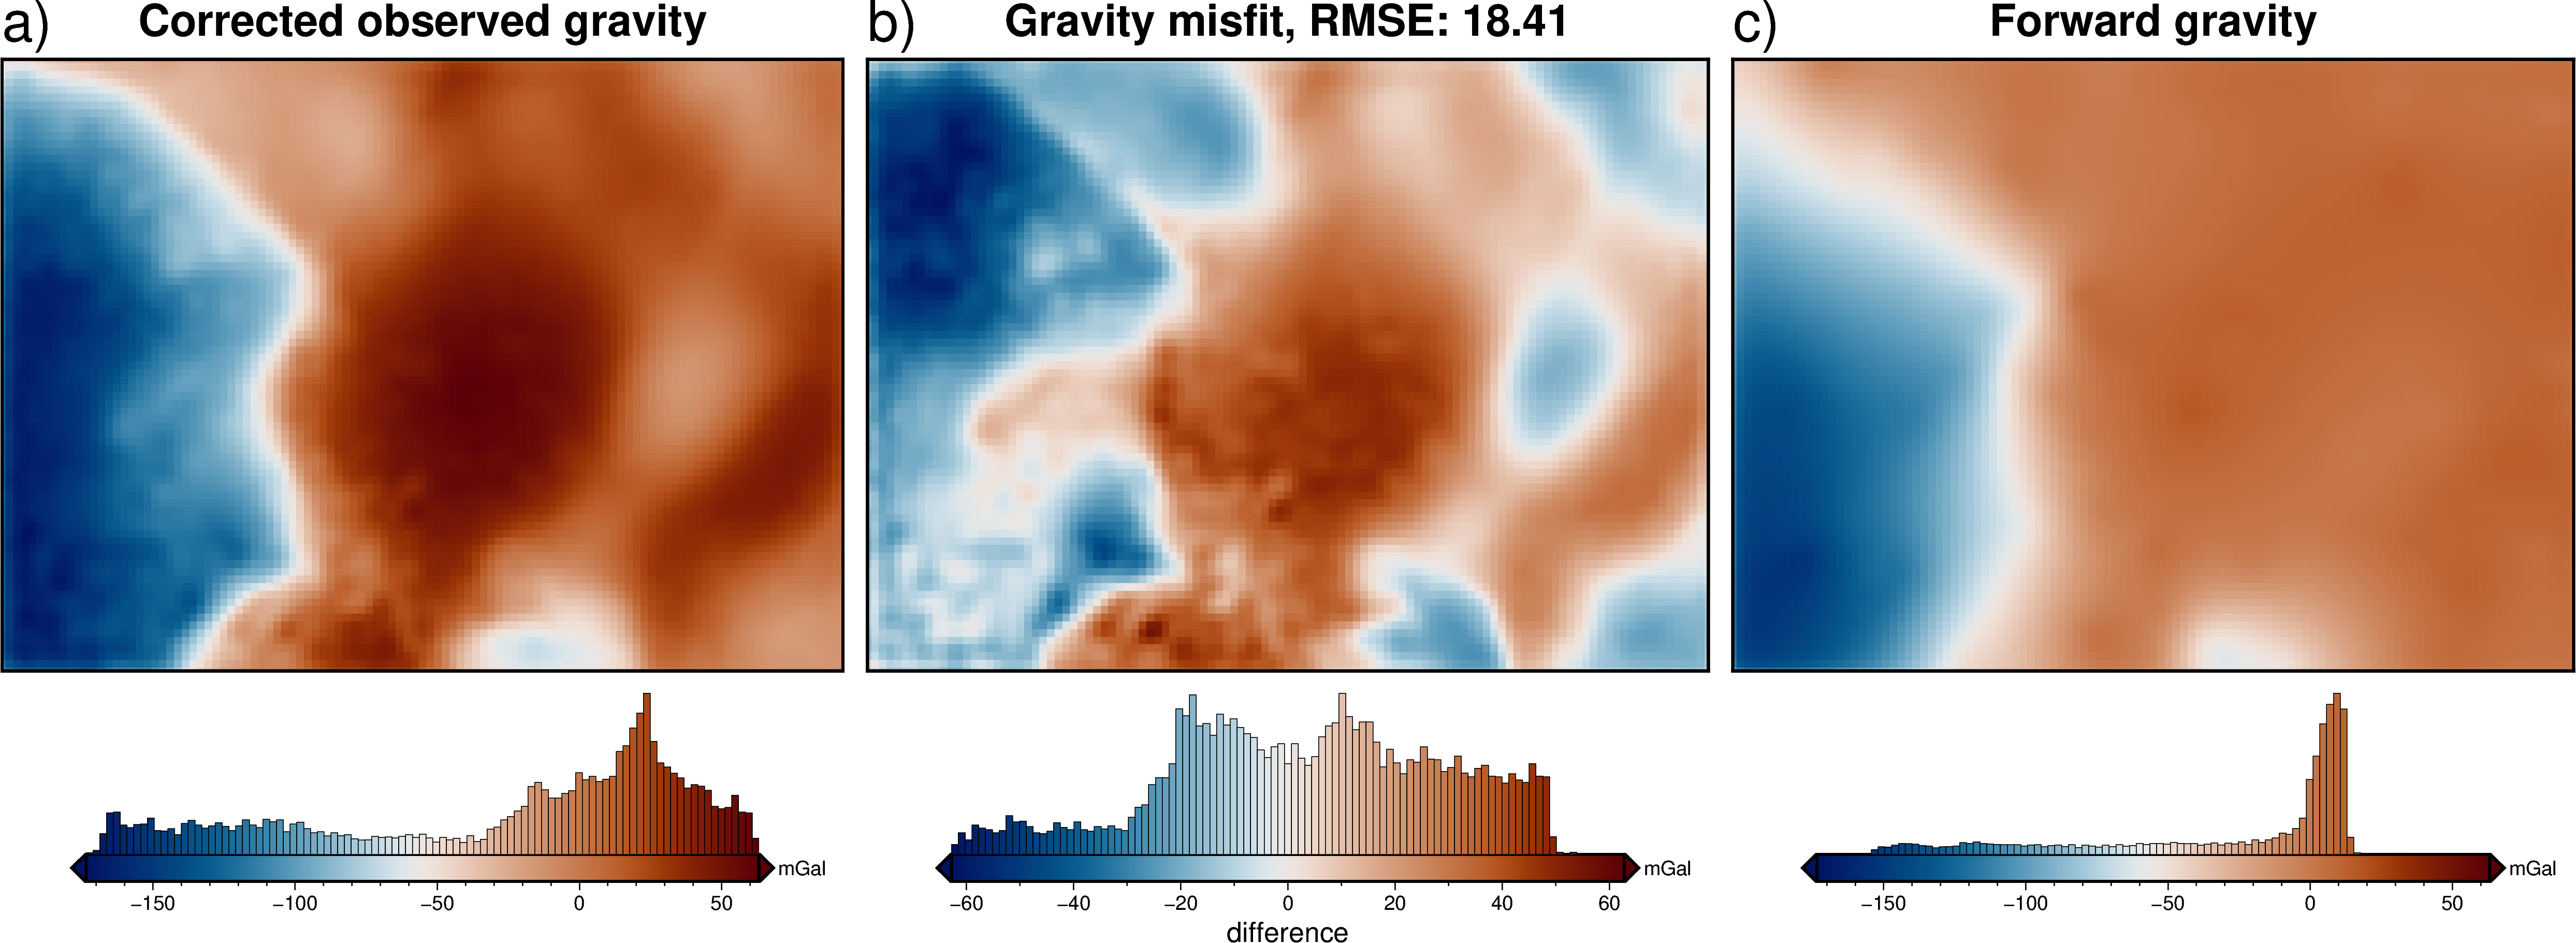

In [47]:
plots.misfit_plotting(
    full_res_grav,
    grav_spacing=layer_spacing,
    plot_type='pygmt',
    input_forward_column = 'bed_forward',
    input_grav_column = 'Gobs_corr',
    )

### Save and load results

In [48]:
full_res_grav.to_csv(
    "../synthetic_data/Ross_Sea_starting_model_forward_gravity.csv.gz",
    sep=",",
    na_rep="",
    header=True,
    index=False,
    encoding="utf-8",
    compression="gzip",
) 

In [9]:
full_res_grav = pd.read_csv(
    "../synthetic_data/Ross_Sea_starting_model_forward_gravity.csv.gz",
    sep=",",
    header="infer",
    index_col=None,
    compression="gzip",
)

full_res_grav

northing   easting        Gobs  upward  water_forward   Gobs_corr  \
0    -1900000.0 -300000.0 -110.551061  1000.0      -0.161138 -110.341227   
1    -1900000.0 -295000.0 -120.117578  1000.0      -0.174697 -119.894185   
2    -1900000.0 -290000.0 -128.074204  1000.0      -0.178454 -127.847054   
3    -1900000.0 -285000.0 -132.115085  1000.0      -0.181105 -131.885283   
4    -1900000.0 -280000.0 -131.913548  1000.0      -0.183105 -131.681747   
...         ...       ...         ...     ...            ...         ...   
8986 -1500000.0  230000.0   -1.488473  1000.0       0.134289   -1.574066   
8987 -1500000.0  235000.0    0.437614  1000.0       0.132347    0.353963   
8988 -1500000.0  240000.0    0.703969  1000.0       0.130925    0.621740   
8989 -1500000.0  245000.0   -0.754553  1000.0       0.128878   -0.834735   
8990 -1500000.0  250000.0   -2.932893  1000.0       0.118307   -3.002504   

      bed_forward     misfit  
0      -99.240135 -11.101091  
1     -114.492793  -5.401391  
2     -118.069619  -9.777435  
3     -118.979535 -12.905748  
4     -118.918397 -12.763350  
...           ...        ...  
8986     1.390349  -2.964414  
8987     1.673562  -1.319600  
8988     1.926418  -1.304678  
8989     1.826766  -2.661501  
8990    -1.316152  -1.686353  

[8991 rows x 8 columns]

returning original grid


grd2cpt [ERROR]: Making a continuous cpt from a discrete cpt may give unexpected results!


returning original grid


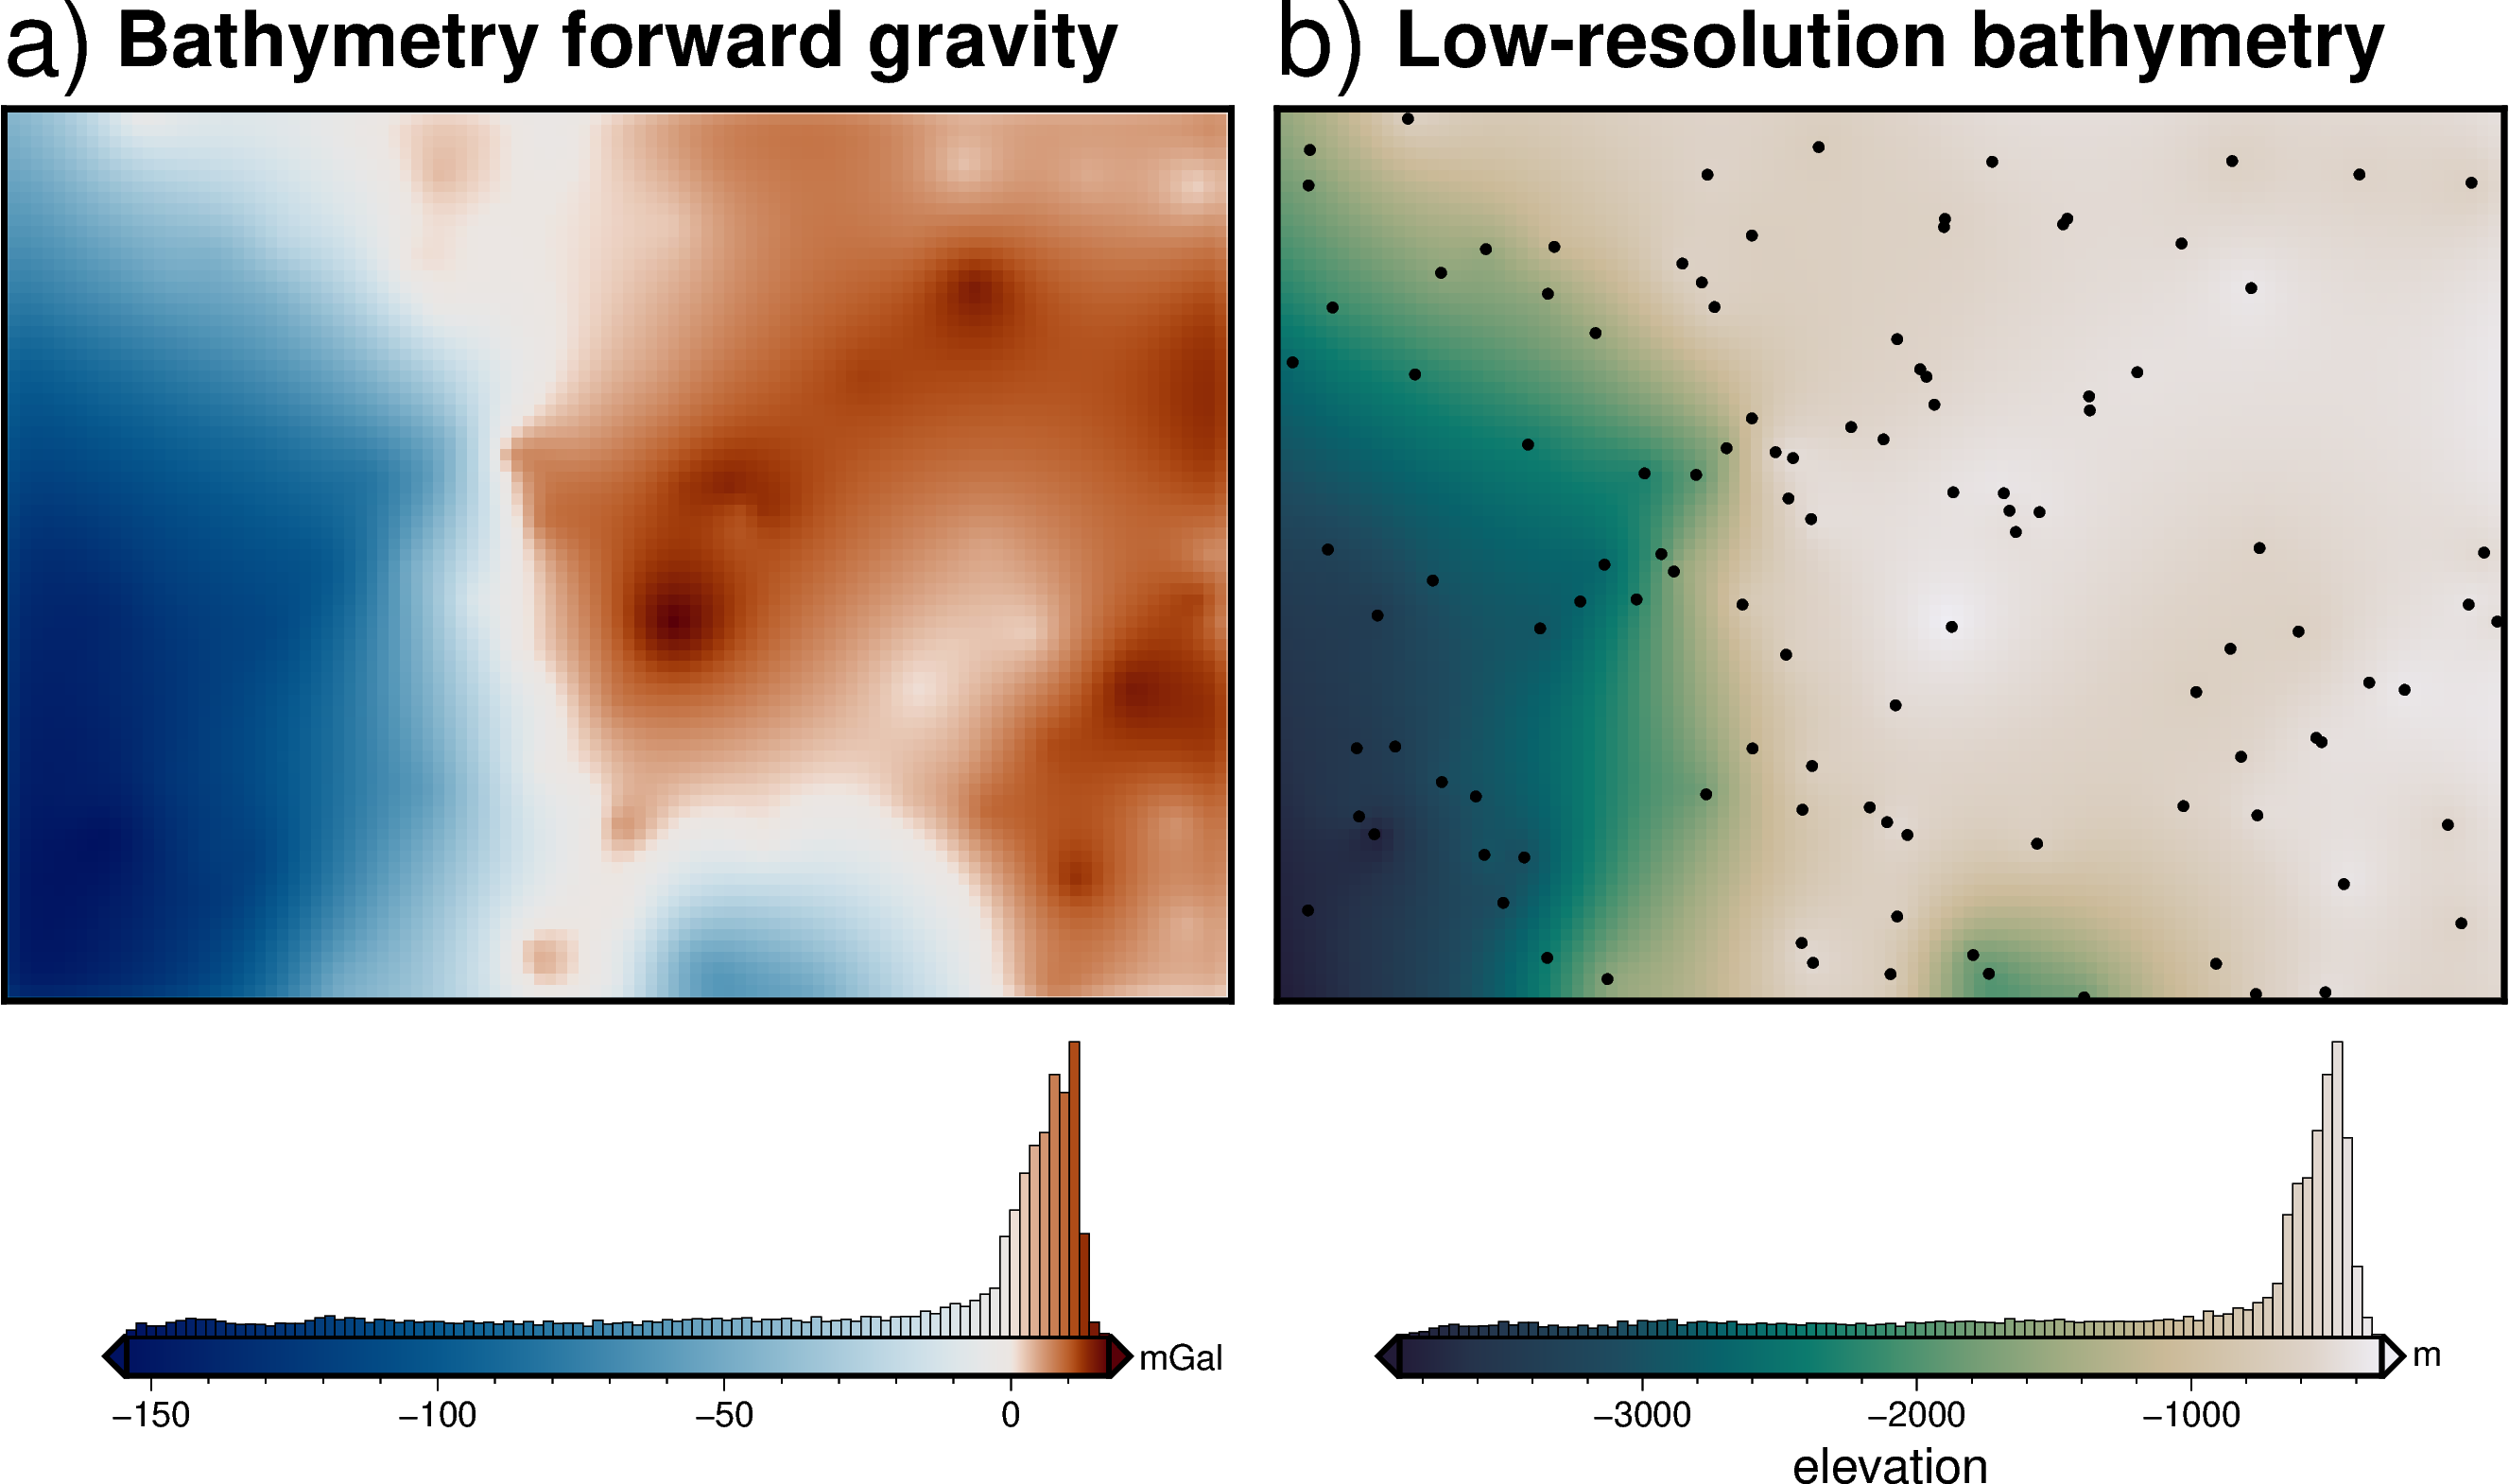

In [36]:
# plot layer 2 gravity
fig = maps.plot_grd(
    grid=bed_forward,
    fig_height=8,
    cmap="vik+h0",
    region=buffer_region,
    title="Bathymetry forward gravity",
    cbar_unit="mGal",
    show_region=inversion_region,
    hist=True,
    cbar_yoffset=3,
)
fig.text(
    position='TL',
    justify='BL',
    text = "a)",
    font = '26p,Helvetica,black',
    offset = 'j0/.3',
    no_clip=True,
)
# plot layer 2 topography
fig = maps.plot_grd(
    grid=lowres_bed,
    fig_height=8,
    cmap="rain",
    reverse_cpt=True,
    region=buffer_region,
    grd2cpt=True,
    title="Low-resolution bathymetry",
    cbar_label="elevation",
    cbar_unit="m",
    show_region=inversion_region,
    hist=True,
    cbar_yoffset=3,
    fig=fig,
    origin_shift="xshift",
    points=constraint_points.rename(columns = {"easting":"x","northing":"y"}),
    points_style="c0.1c",
)
fig.text(
    position='TL',
    justify='BL',
    text = "b)",
    font = '26p,Helvetica,black',
    offset = 'j0/.3',
    no_clip=True,
)
fig.show()

## Regional - Residual seperation

The `corrected observed gravity` is the combination of the signal from the density contrasts of `bathymetry` and `basement`. Both of these signals contain long-wavelength components, since both surface have long-wavelength topographic features. The `bathymetry` signal also contains short-wavelength components. Deeper in the crust, further away from the gravity observation points, these short-wavelength components decrease in amplitude. This means the majority the short-wavelength signal in the `corrected observed gravity` is resulting from the density contrast of the `bathymetry`. This is the signal we want to isolate and input into the inversion. 

To do this, we need to seperate the gravity misfit into a `regional` component and a `residual` component. This `regional` field should theoretically contain every gravity signal other than the that resulting from the `bathymetry` surface. Additionaly, this `residual` component should theoretically represent the gravity anomaly due to the difference between the true `bathymetry` and the low-resolution `bathymetry`. 

If we fail to accurately remove the `regional` signal, the resulting `bathymetry` after the inversion will contain long-wavelength topography, resulting from the `regional` gravity field. 

Since we created the synthetic model, we precisely know the regional component (the forward gravity of the `basement`), and can thus tune our regional-residual seperation method to accurately remove the regional field. 

### optimize the regional-residual seperation

We have 4 methods to seperate the regional misfit from the residual misfit.
1) `Filter` method: Apply a low-pass filter to the misfit
2) `Trend` method: Fit a trend to the misfit
3) `Constraints` method: Sample and grid the misfit only at constraint points, where we know the true layer depth
4) `Equivalent-Sources` method: Predict the gravity anomaly resulting from a serious of deep sources.

Each of these methods has 1 parameter to tune. Respectively, these are 
1) gaussian low-pass filter width (1km - 1000km)
2) trend order (1 - 20)
3) gridding tension factor (0 - 1)
4) source depth (10km - 10,000km)

The optimization will explore the parameter space of each of these, and return the parameters which result in your choice of:
a) a `regional misfit` closest to the true layer 3 forward gravity,
b) the smallest `residuals` at the constraint points

Since we know the true `regional` field, we will use method a). For a true inversion where you don't know the `regional` field, you can use method b). This method finds the seperation method which minimize the `residuals` at contraint points. Since at these contraint points you know the starting layer elevation is accurate, the misfit should be entirely due to the `regional` field, and the `residual` should be close to 0. 

Choose to either run all 4 methods in the same optimization, or run each seperately. 

In [10]:
regional_kwargs = dict(
    input_grav=full_res_grav,
    input_forward_column = 'bed_forward',
    input_grav_column = 'Gobs_corr',
    grav_spacing=layer_spacing,
    inversion_region=inversion_region,
    true_regional=true_regional_grav,
    constraints=constraint_points,
    block_size=layer_spacing*10,
)

## Optimize all methods individually

In [23]:
# set comparison method
# comparison_method='minimize_constraints'
comparison_method='regional_comparison'

methods = [
    "filter", 
    "trend",
    "constraints", 
    "eq_sources"
    ]

# for i in methods:
#     # set name and storage for the optimization
#     study_name = f"Ross_Sea_regional_seperation_indiv_{i}_{comparison_method}"
#     storage = JournalStorage(JournalFileStorage(f"../optimization_logs/{study_name}.log"))

#     # set number of runs
#     n_trials=50

#     # create a new study
#     study = optuna.create_study(
#         study_name=study_name,
#         storage=storage,
#         direction="minimize",
#         # sampler=optuna.samplers.TPESampler(n_startup_trials=int(n_trials/3)),
#         sampler=optuna.integration.BoTorchSampler(n_startup_trials=int(n_trials/3)),
#         load_if_exists=True,
#         )

#     # define the objective function
#     objective = opti.optimal_regional_params(
#         comparison_method = comparison_method,
#         regional_method = i,
#         filter_limits = [10e3, 1000e3, 10e3], # 100 options
#         trend_limits = [1, 20, 1], # 20 options
#         constraints_limits = [0, 1, 0.01], # 101 options
#         eq_sources_limits = [10e3, 10000e3, 10e3], # 1000 options
#         **regional_kwargs)

#     # run the optimization
#     with inv_utils.HiddenPrints():
#         with warnings.catch_warnings():
#             warnings.simplefilter("ignore")
#             study, study_df = opti.optuna_parallel(
#                 study_name=study_name,
#                 study_storage=storage,
#                 objective=objective,
#                 n_trials=n_trials,
#                 maximize_cpus=True,
#             )

/tmp/ipykernel_806221/3424513478.py:5: ExperimentalWarning:

JournalStorage is experimental (supported from v3.1.0). The interface can change in the future.




########## filter ##########
number                                       47
value                                   4.07822
datetime_start       2023-03-05 10:53:19.662710
datetime_complete    2023-03-05 10:53:59.751144
duration                 0 days 00:00:40.088434
params_filter                            150000
state                                  COMPLETE
Name: 47, dtype: object
returning original grid
returning original grid


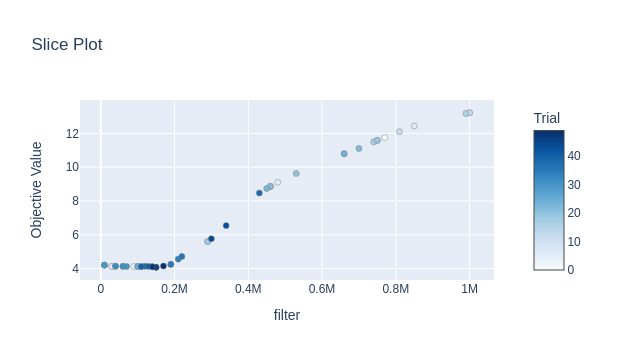


########## trend ##########
number                                       24
value                                  4.215276
datetime_start       2023-03-05 10:54:02.568821
datetime_complete    2023-03-05 10:54:25.960204
duration                 0 days 00:00:23.391383
params_trend                                 20
state                                  COMPLETE
Name: 24, dtype: object


/tmp/ipykernel_806221/3424513478.py:5: ExperimentalWarning:

JournalStorage is experimental (supported from v3.1.0). The interface can change in the future.



returning original grid
returning original grid


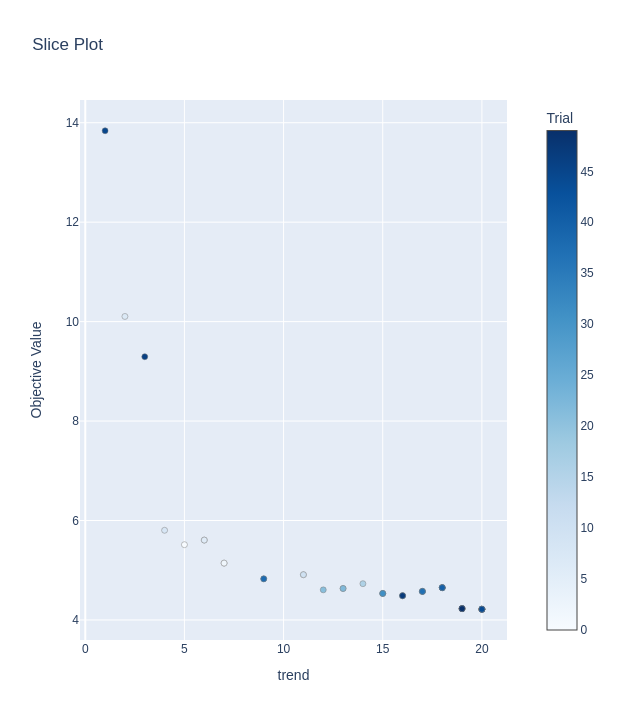


########## constraints ##########
number                                        41
value                                   2.956944
datetime_start        2023-03-05 10:54:54.404999
datetime_complete     2023-03-05 10:55:46.735226
duration                  0 days 00:00:52.330227
params_constraints                          0.02
state                                   COMPLETE
Name: 41, dtype: object


/tmp/ipykernel_806221/3424513478.py:5: ExperimentalWarning:

JournalStorage is experimental (supported from v3.1.0). The interface can change in the future.



returning original grid
returning original grid


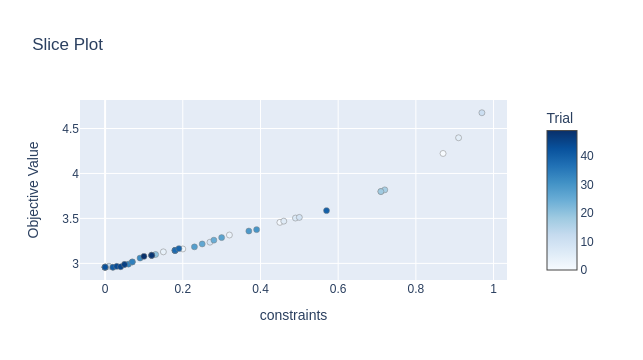


########## eq_sources ##########
number                                       23
value                                  4.330023
datetime_start       2023-03-05 10:55:54.940701
datetime_complete    2023-03-05 10:56:15.637448
duration                 0 days 00:00:20.696747
params_eq_sources                         70000
state                                  COMPLETE
Name: 23, dtype: object


/tmp/ipykernel_806221/3424513478.py:5: ExperimentalWarning:

JournalStorage is experimental (supported from v3.1.0). The interface can change in the future.



returning original grid
returning original grid


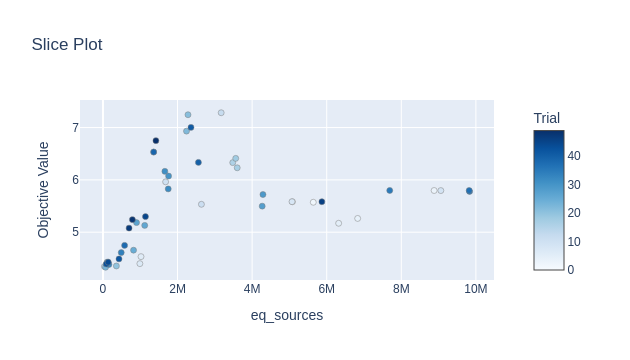

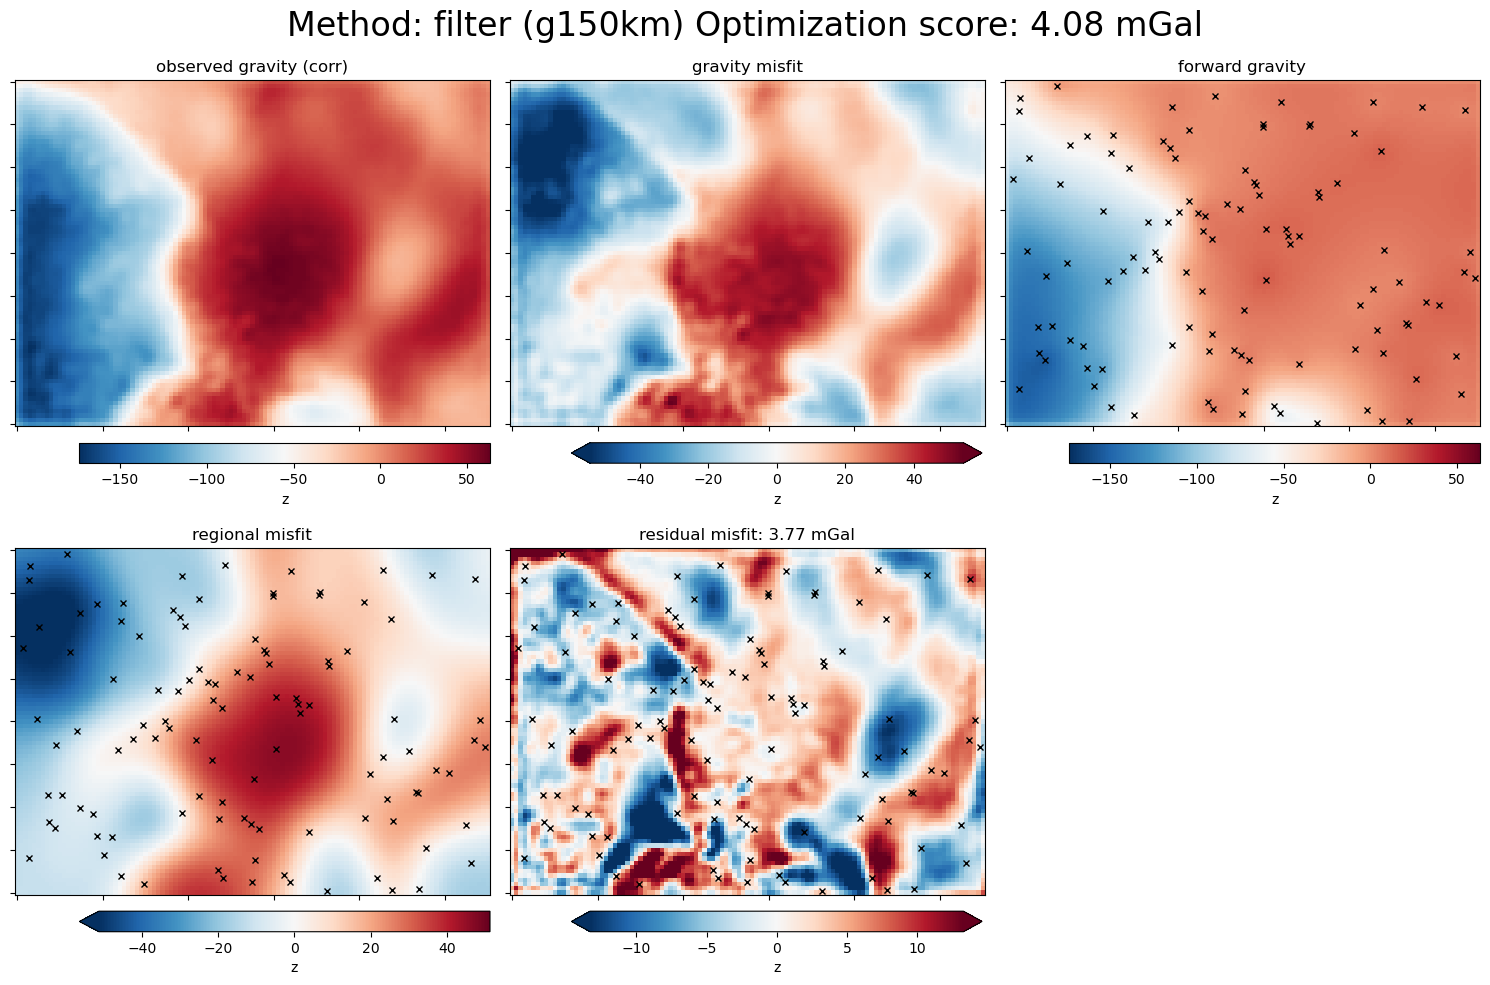

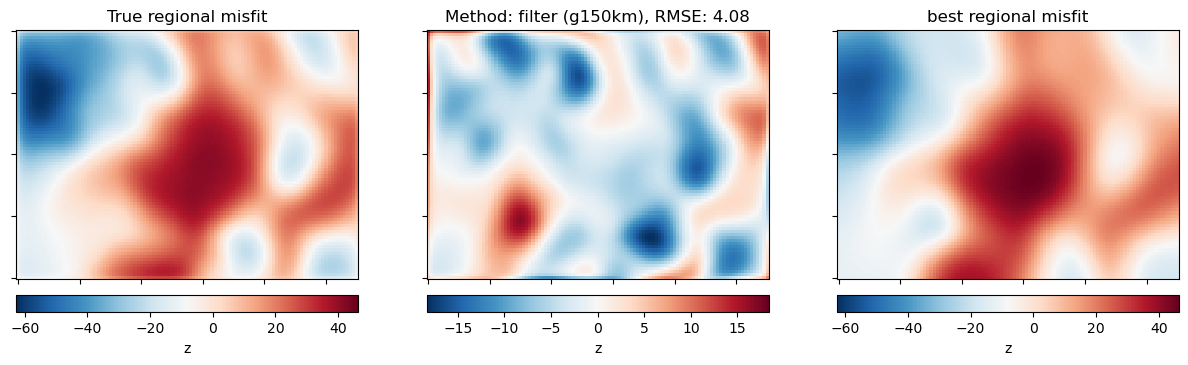

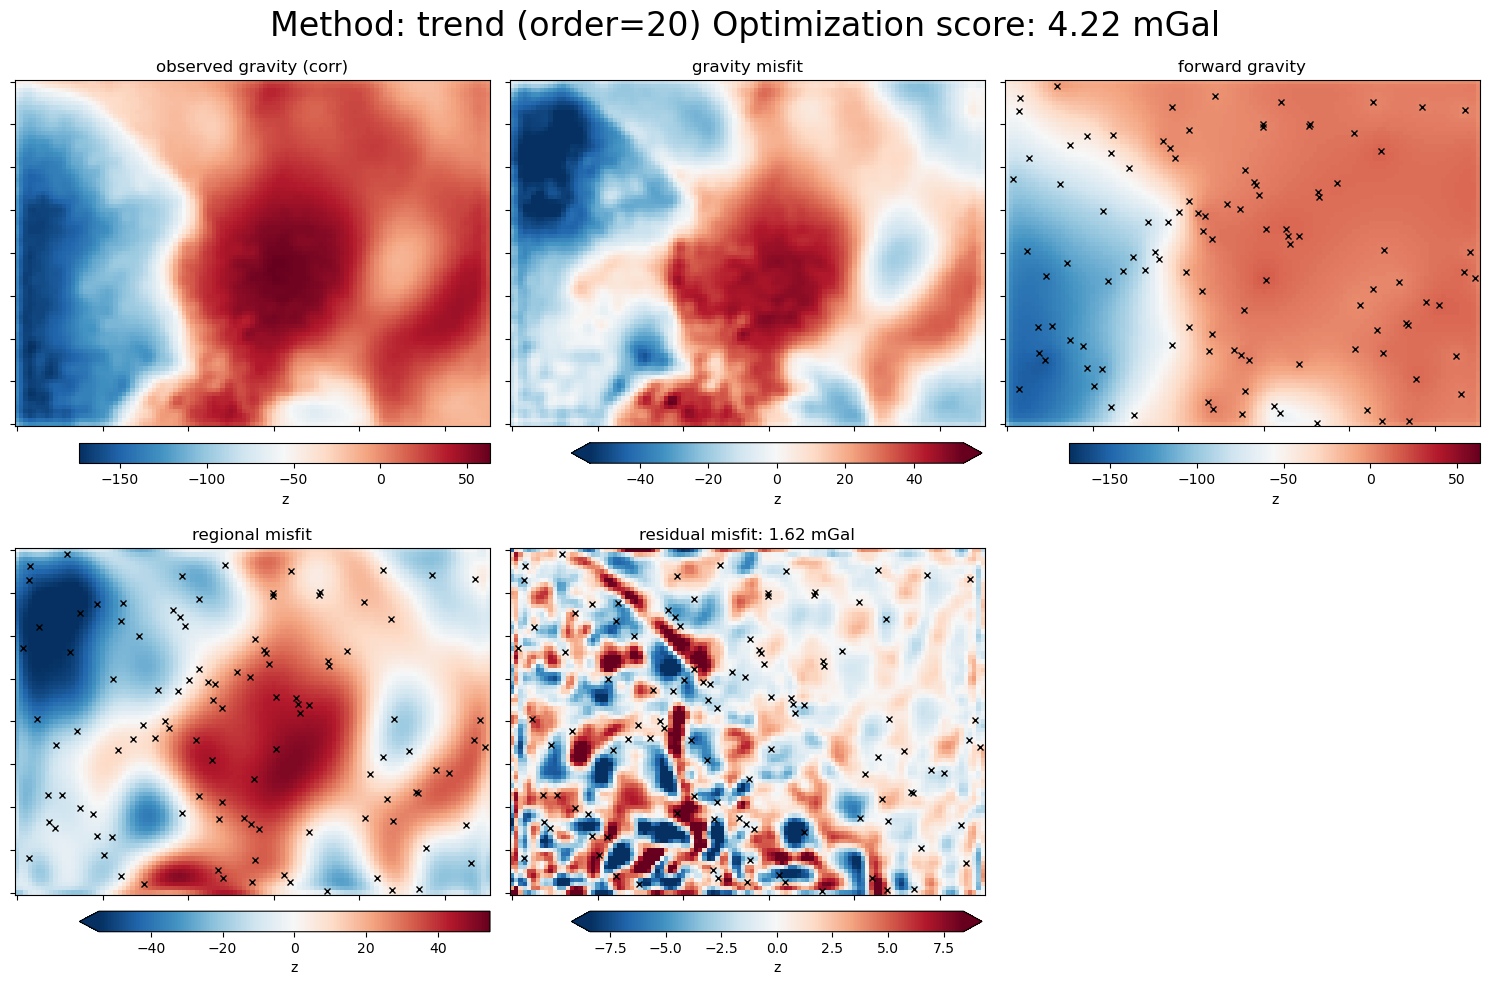

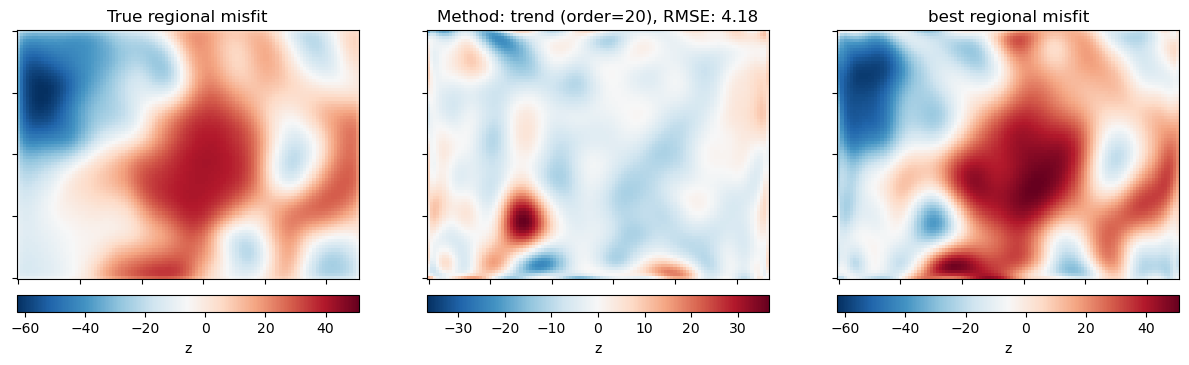

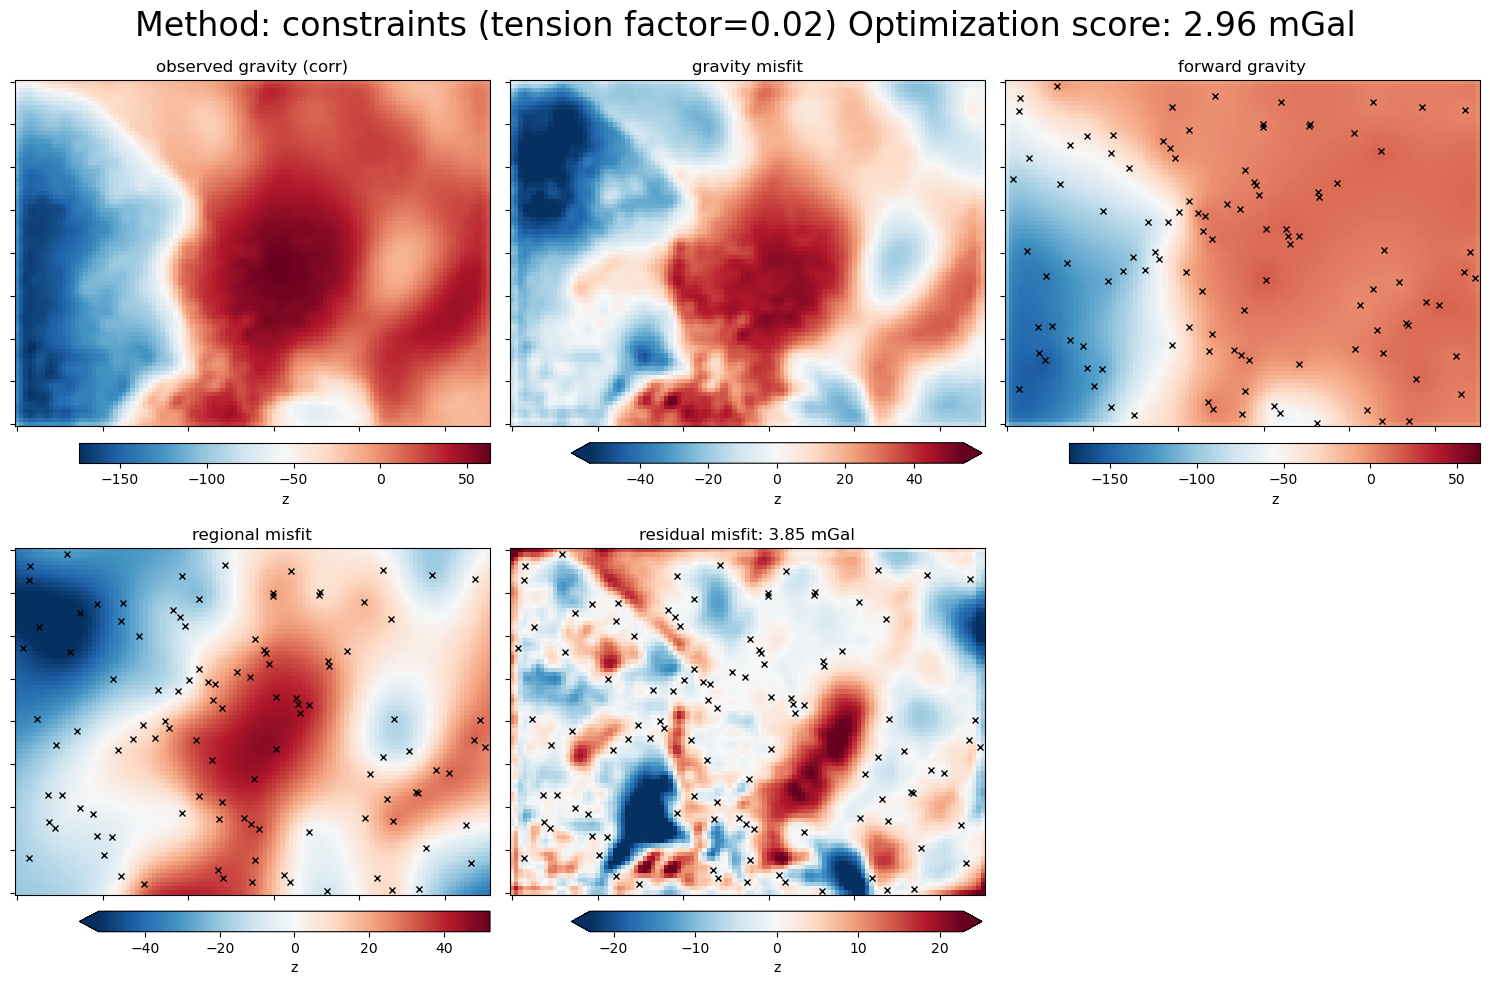

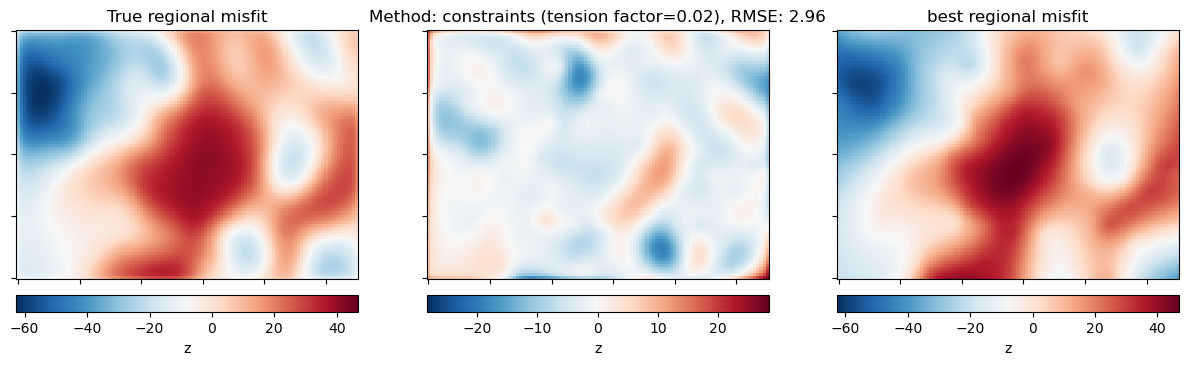

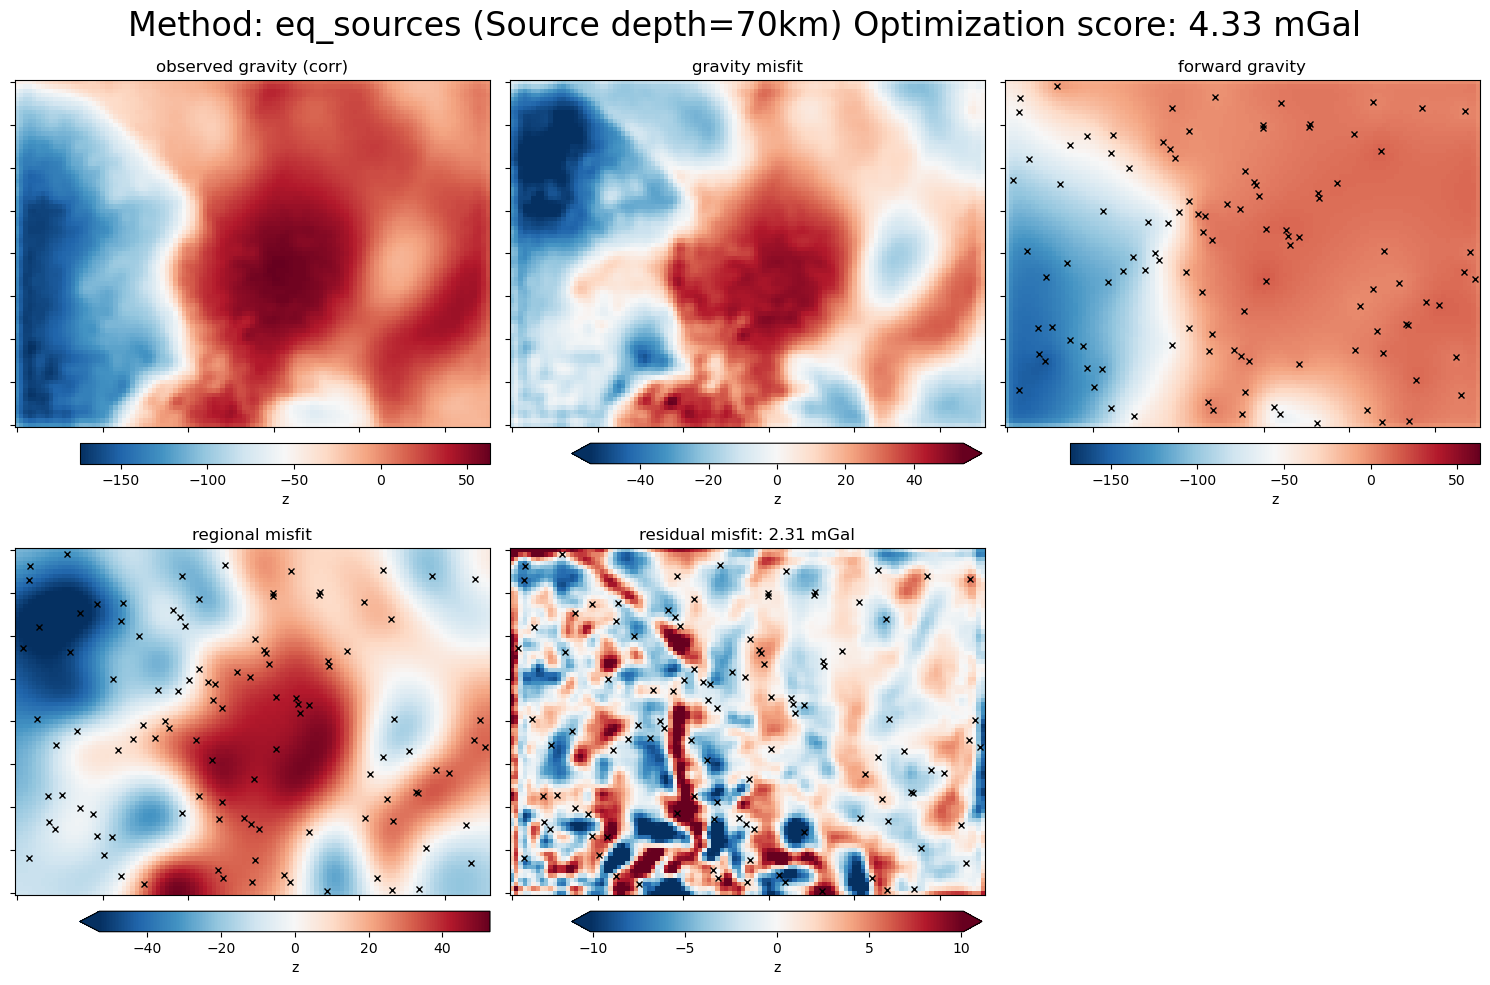

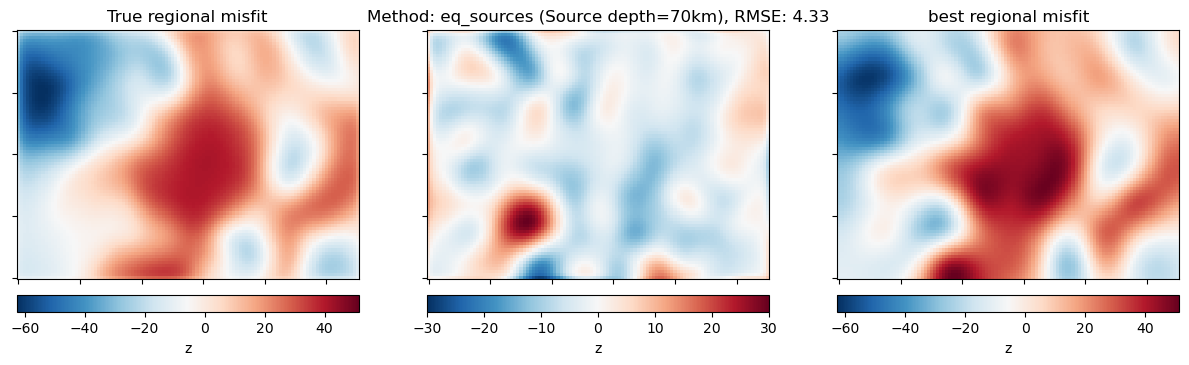

In [24]:
# load studies
study_dfs = []
for i in methods:
    study_name = f"Ross_Sea_regional_seperation_indiv_{i}_{comparison_method}"
    storage = JournalStorage(JournalFileStorage(f"../optimization_logs/{study_name}.log"))
    study = optuna.load_study(storage=storage, study_name=study_name)
    study_df = study.trials_dataframe()
    study_dfs.append(study_df) 
    
    # plot results
    plots.plot_best_param(
        study_df, 
        comparison_method, 
        regional_method=i, 
        **regional_kwargs)
    optuna.visualization.plot_slice(study).show()
    
studies = dict(zip(methods, study_dfs))

for k, v in studies.items():
    v['params_method']=k

regional_sep_combined_studies = pd.concat(studies.values(), ignore_index=True).sort_values(by="value")

In [25]:
df = regional_sep_combined_studies
df.head()

number     value             datetime_start          datetime_complete  \
114      14  2.956944 2023-03-05 10:54:54.319805 2023-03-05 10:55:10.349214   
141      41  2.956944 2023-03-05 10:54:54.404999 2023-03-05 10:55:46.735226   
115      15  2.957451 2023-03-05 10:54:54.319929 2023-03-05 10:55:11.638263   
123      23  2.957451 2023-03-05 10:54:54.363910 2023-03-05 10:55:22.819075   
112      12  2.957451 2023-03-05 10:54:54.319468 2023-03-05 10:55:08.111256   

                  duration  params_filter     state params_method  \
114 0 days 00:00:16.029409            NaN  COMPLETE   constraints   
141 0 days 00:00:52.330227            NaN  COMPLETE   constraints   
115 0 days 00:00:17.318334            NaN  COMPLETE   constraints   
123 0 days 00:00:28.455165            NaN  COMPLETE   constraints   
112 0 days 00:00:13.791788            NaN  COMPLETE   constraints   

     params_trend  params_constraints  params_eq_sources  
114           NaN                0.02                NaN  
141           NaN                0.02                NaN  
115           NaN                0.00                NaN  
123           NaN                0.00                NaN  
112           NaN                0.00                NaN

In [26]:
best_filter = df[df.params_method == 'filter'].iloc[0].number
best_trend = df[df.params_method == 'trend'].iloc[0].number
best_constraints = df[df.params_method == 'constraints'].iloc[0].number
best_eq_sources = df[df.params_method == 'eq_sources'].iloc[0].number

print(f"best trial w/ method = filter: index {best_filter}")
print(f"best trial w/ method = trend: index {best_trend}")
print(f"best trial w/ method = constraints: index {best_constraints}")
print(f"best trial w/ method = eq. sources: index {best_eq_sources}")

best trial w/ method = filter: index 46
best trial w/ method = trend: index 25
best trial w/ method = constraints: index 14
best trial w/ method = eq. sources: index 23


## Best regional seperation

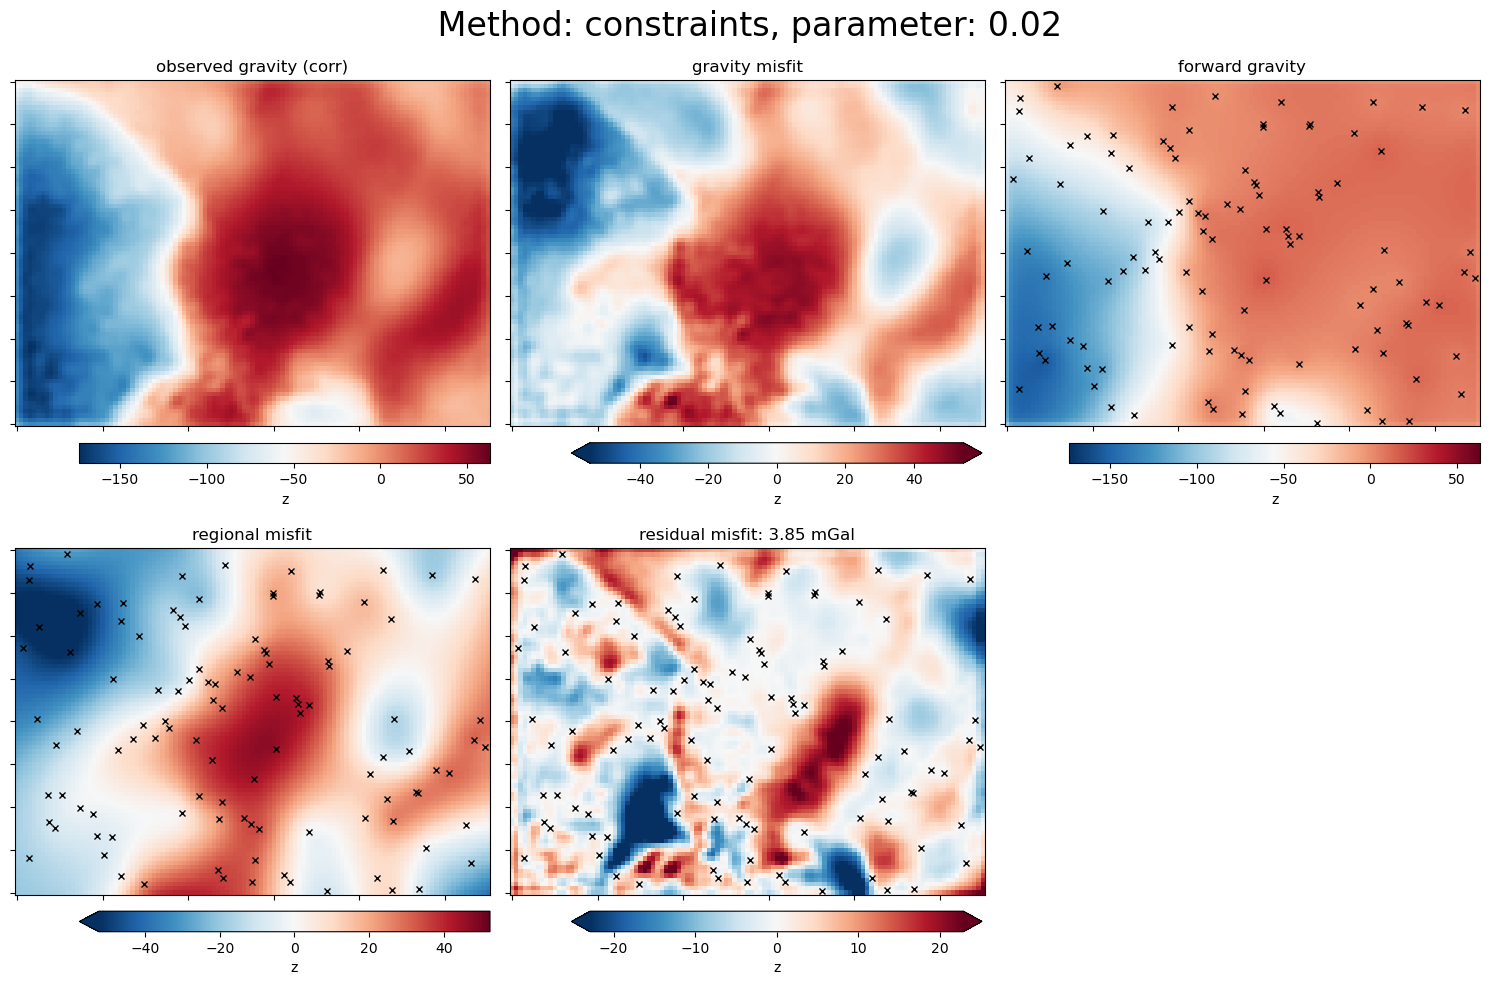

In [27]:
# choose the regional method:
# regional_method = "filter"
# regional_method = "trend"
# regional_method = "constraints"
# regional_method = "eq_sources"
regional_method = df.params_method.iloc[0]

# set the parameter:
# contraints: 1 results in pedastals, 0 is good,
# param = .23

# or use the best parameter from the optimization
param = df[df[f"params_{regional_method}"].notnull()].iloc[0][f"params_{regional_method}"]

df_anomalies = inv.regional_seperation(
        regional_method=regional_method,
        filter=f"g{param}",
        trend=param,
        tension_factor=param,
        eq_sources=param,
        **regional_kwargs,
    )

anom_grids = plots.anomalies_plotting(
        df_anomalies,
        region=inversion_region,
        grav_spacing=layer_spacing,
        title=f" Method: {regional_method}, parameter: {param}",
        constraints=constraint_points,
        input_forward_column = 'bed_forward',
        input_grav_column = 'Gobs_corr',
    )

In [28]:
df_anomalies.describe()

northing        easting         Gobs  upward  water_forward  \
count  8.991000e+03    8991.000000  8991.000000  8991.0    8991.000000   
mean  -1.700000e+06  -25000.000000   -25.330617  1000.0      -0.015573   
std    1.169110e+05  160217.107984    66.300459     0.0       0.103897   
min   -1.900000e+06 -300000.000000  -173.712711  1000.0      -0.212600   
25%   -1.800000e+06 -165000.000000   -81.438298  1000.0      -0.100919   
50%   -1.700000e+06  -25000.000000     0.000000  1000.0       0.000000   
75%   -1.600000e+06  115000.000000    24.686705  1000.0       0.065338   
max   -1.500000e+06  250000.000000    63.064281  1000.0       0.181674   

         Gobs_corr  bed_forward       misfit          reg          res  
count  8991.000000  8991.000000  8991.000000  8991.000000  8991.000000  
mean    -25.266348   -28.254533     2.988185     2.526102     0.462083  
std      66.227898    49.155304    25.810490    23.583553     8.648800  
min    -173.454972  -154.292351   -62.763105   -58.576996   -47.005614  
25%     -81.412976   -57.522229   -15.343216   -12.380827    -3.030392  
50%       0.000000     0.000000     3.966377     4.875815     0.238262  
75%      24.680346     7.613033    23.057543    19.198823     4.656135  
max      63.155404    17.138664    56.080437    46.919151    31.248802

# Plot Inputs

In [21]:
# grid the residual misfit
residual = pygmt.surface(
        data=df_anomalies[["easting", "northing", "res"]],
        region=inversion_region,
        spacing=layer_spacing,
        T=0.25,
        # M="0c",
        registration=registration,
    )

returning original grid


grd2cpt [ERROR]: Making a continuous cpt from a discrete cpt may give unexpected results!


returning original grid


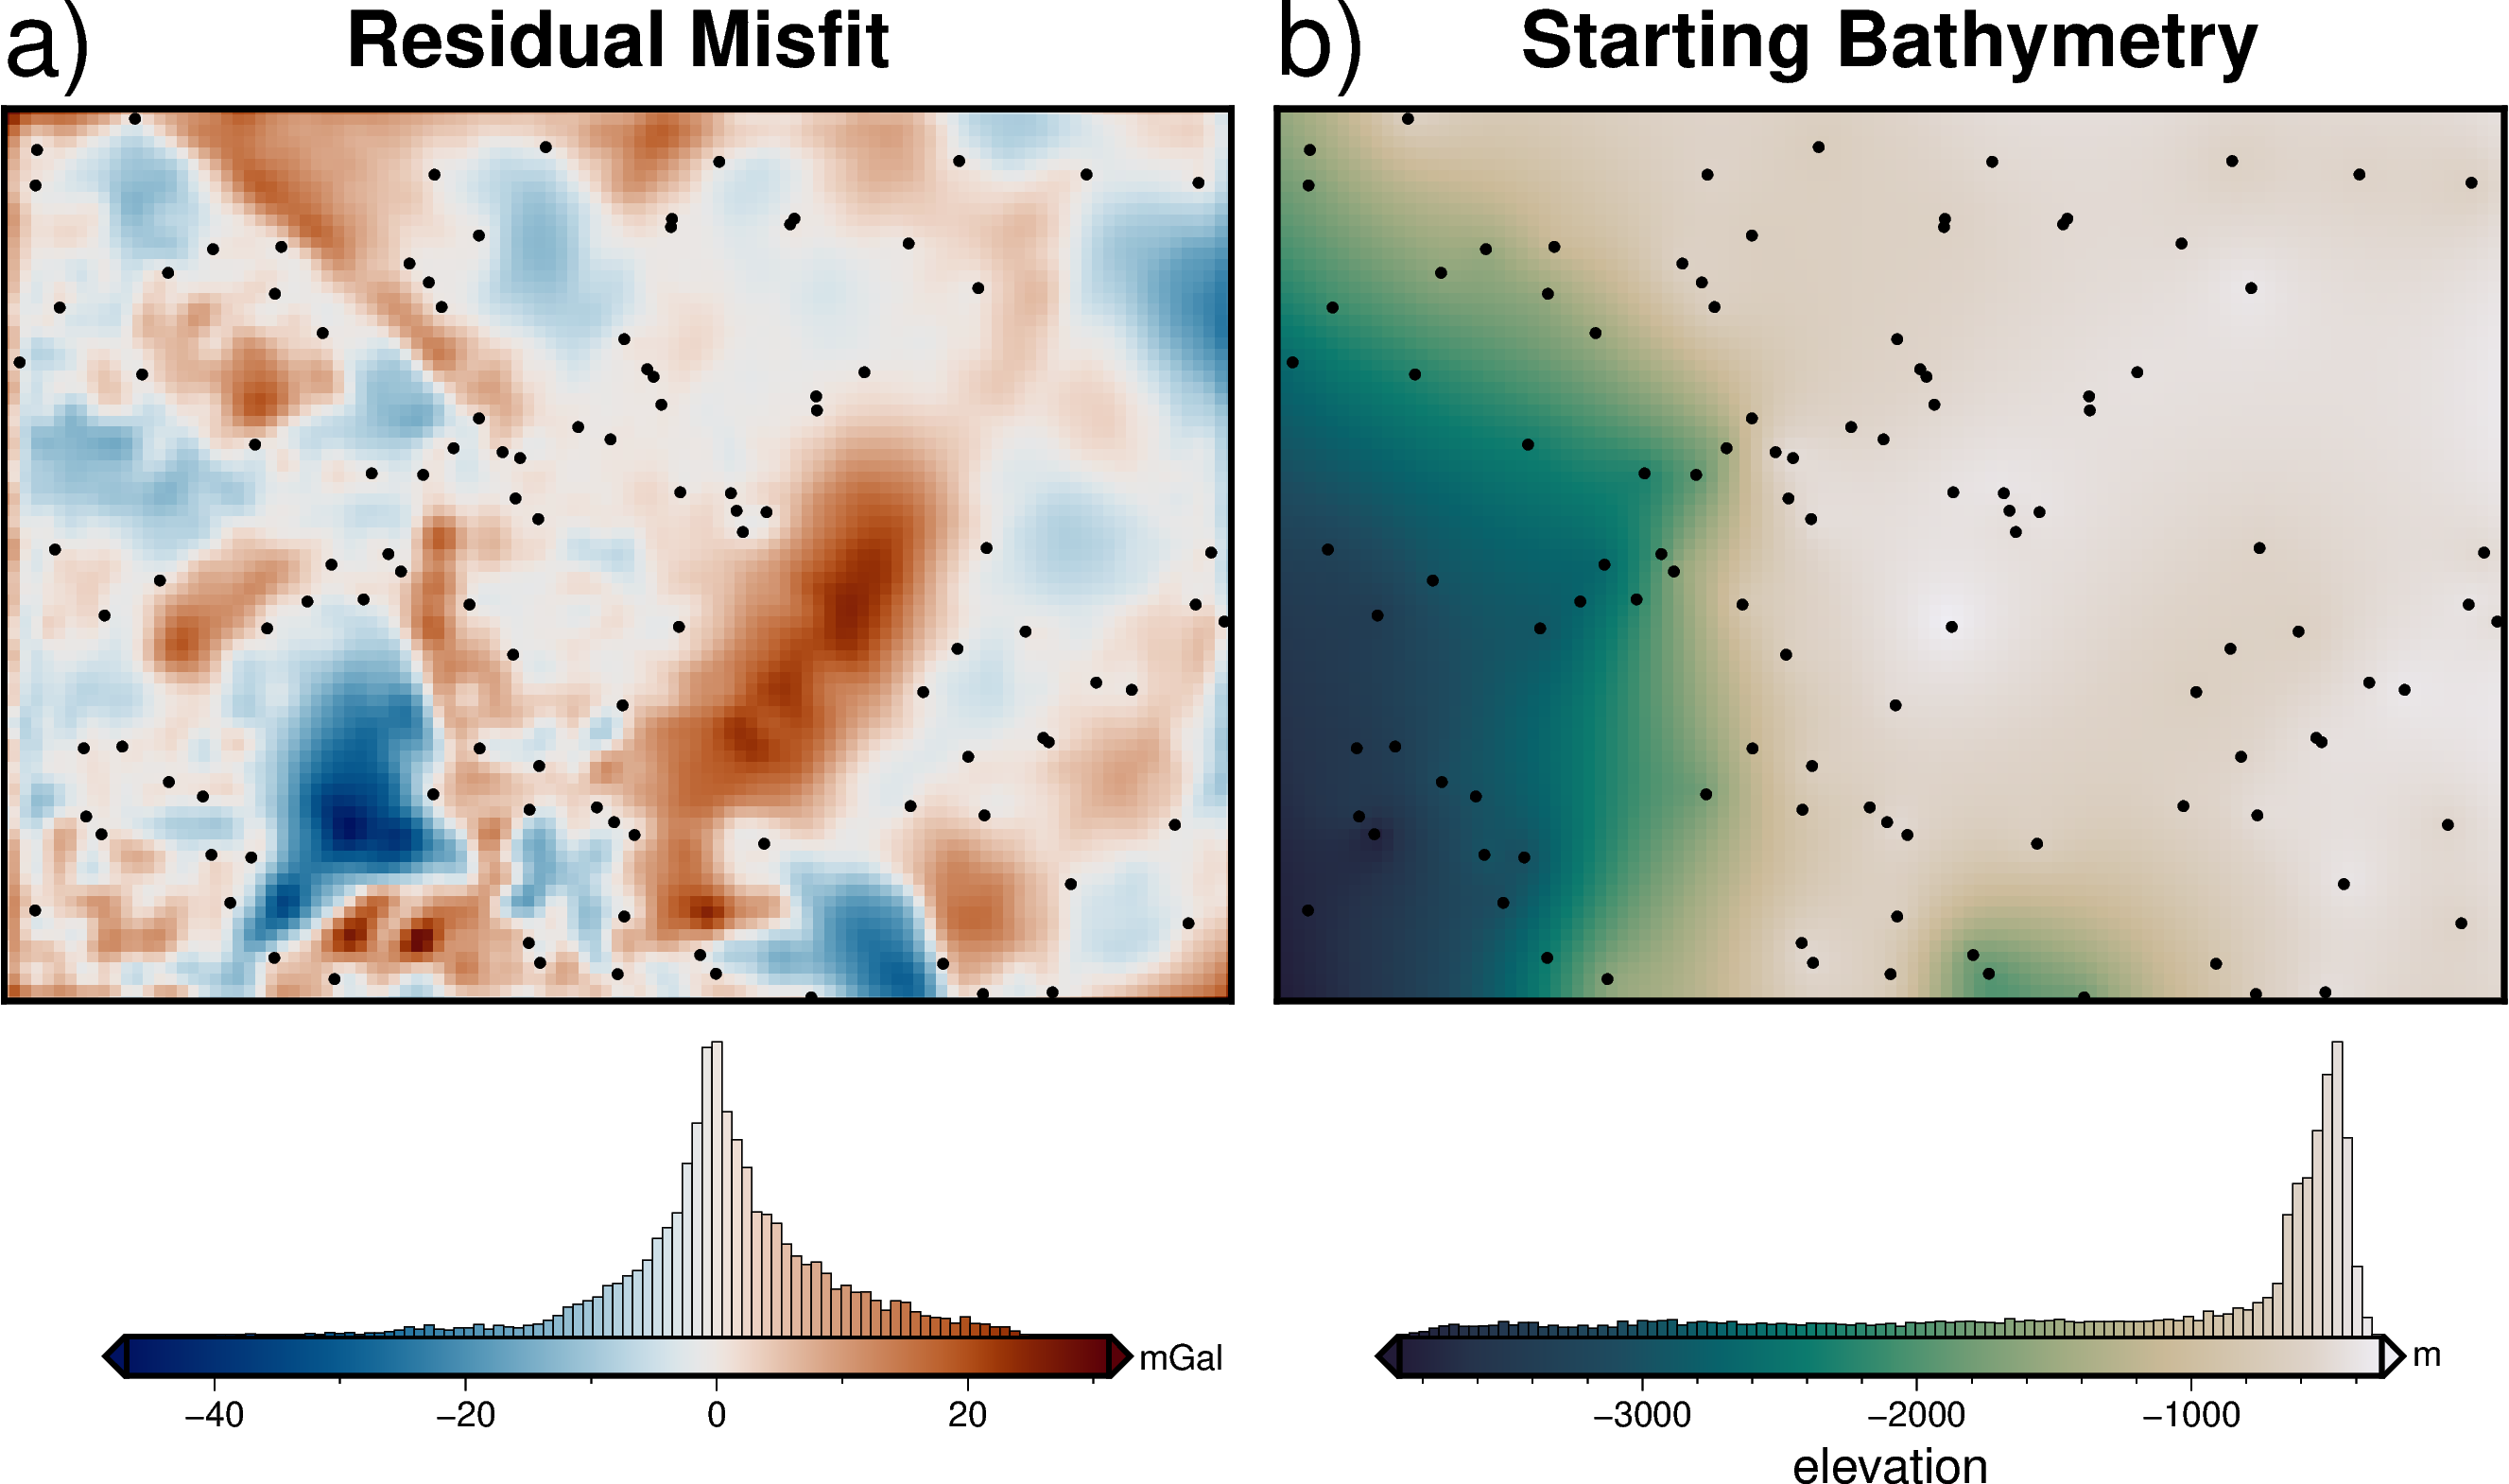

In [27]:
# plot residual misfit
fig = maps.plot_grd(
    grid=residual,
    fig_height=8,
    cmap="vik+h0",
    region=buffer_region,
    title="Residual Misfit",
    cbar_unit="mGal",
    show_region=inversion_region,
    points=constraint_points.rename(columns = {"easting":"x","northing":"y"}),
    points_style="c0.1c",
    hist=True,
    cbar_yoffset=3,
)
fig.text(
    position='TL',
    justify='BL',
    text = "a)",
    font = '26p,Helvetica,black',
    offset = 'j0/.3',
    no_clip=True,
)

# plot layer 2
fig = maps.plot_grd(
    grid=lowres_bed,
    fig_height=8,
    cmap="rain",
    reverse_cpt=True,
    region=buffer_region,
    grd2cpt=True,
    title="Starting Bathymetry",
    cbar_label="elevation",
    cbar_unit="m",
    show_region=inversion_region,
    points=constraint_points.rename(columns = {"easting":"x","northing":"y"}),
    points_style="c0.1c",
    hist=True,
    cbar_yoffset=3,
    fig=fig,
    origin_shift="xshift",
)
fig.text(
    position='TL',
    justify='BL',
    text = "b)",
    font = '26p,Helvetica,black',
    offset = 'j0/.3',
    no_clip=True,
)

fig.show()

# Inversion

Now that we have $G_{misfit}$, we can run an inversion to attempt to recover the true Layer 2 topography. 

To determine optimal inversion parameters, we will run an optimization routine which minimizes the root median square error (RMSE) of the ending Surface 2 to the true Surface 2. 

The parameters we will test are:
* Jacobian methods (annulus vs small prisms)
* Solver methods (Scipy lsqr vs Verde lsqr)
* Solver damping
* max prism change per iteration

In [152]:
# set kwargs for inversion
inversion_kwargs = dict(
    input_grav = df_anomalies,
    input_grav_column = 'Gobs_corr',
    prism_layer=bed_prisms,
    max_iterations = 2,
    l2_norm_tolerance = .2,
    delta_l2_norm_tolerance = .8,
)

In [ ]:
# # %%snakeviz 

# prism_results, grav_results, params, elapsed_time = inv.geo_inversion(
#     **inversion_kwargs,
    
#     # deriv_type = "annulus",
#     deriv_type = "prisms",
    
#     # solver_type = "verde least squares",
#     solver_type = "scipy least squares",
    
#     solver_damping = 0.169223,
#     # solver_damping = 1000000
#         )

In [151]:
# results = inv.inversion_RMSE(
#     bed,
#     plot=True,
#     deriv_type = "annulus",
#     # deriv_type = "prisms",
    
#     # solver_type = "verde least squares",
#     solver_type = "scipy least squares",
    
#     solver_damping = 3.942657703873728,#3.942658,
#     # solver_damping = 1000000
#      **inversion_kwargs,
#         )
# results

In [56]:
# grids = plots.plot_inversion_results(
#     grav_results,
#     prism_results, 
#     params,
#     grav_region = inversion_region,
#     grav_spacing = layer_spacing,
#     constraints = constraint_points,
#     # plot_iter_results = False,
#     # plot_topo_results = False,
#     # plot_grav_results = False,
#     iters_to_plot = 4,
#     )


## Optimization

In [153]:
# set name and storage for the optimization
study_name = "Ross_Sea_inversion_with_regional_params_logarithmic_10its"
storage = JournalStorage(JournalFileStorage(f"../optimization_logs/{study_name}.log"))

# set number of runs
n_trials=10

# set objectives
objectives = [
    "RMSE"
    # "duration"
    # "constraints"
]

# set directions
directions=[
    "minimize"
    # "minimize" 
    # "minimize"
]

# create study
study = optuna.create_study(
    study_name=study_name,
    storage=storage,
    directions=directions,
    # sampler=optuna.samplers.TPESampler(n_startup_trials=int(n_trials/3)),
    sampler=optuna.integration.BoTorchSampler(n_startup_trials=int(n_trials/3)),
    load_if_exists=True,
    )

# define the objective function
objective_func = opti.optimal_inversion_params(
    bed,
    # verde_damping_limits = [0, 1e4],
    # scipy_damping_limits = [0, 1],
    verde_damping_limits = [1, 10e3],
    scipy_damping_limits = [10e-4, 10],
    objectives = objectives,
    constraints = constraint_points,
    **inversion_kwargs)

# run the optimization
with inv_utils.HiddenPrints():
    study, study_df = opti.optuna_parallel(
        study_name=study_name,
        study_storage=storage,
        objective = objective_func,
        n_trials=n_trials,
        maximize_cpus=True,
    )

/tmp/ipykernel_806221/1692364734.py:3: ExperimentalWarning:

JournalStorage is experimental (supported from v3.1.0). The interface can change in the future.

/tmp/ipykernel_806221/1692364734.py:28: ExperimentalWarning:

BoTorchSampler is experimental (supported from v2.4.0). The interface can change in the future.

[I 2023-03-06 13:41:09,857] A new study created in Journal with name: Ross_Sea_inversion_with_regional_params_logarithmic_10its


Optimizing:   0%|          | 0/10 [00:00<?, ?it/s]

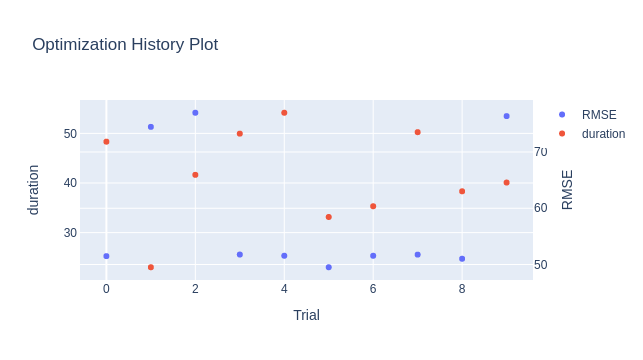

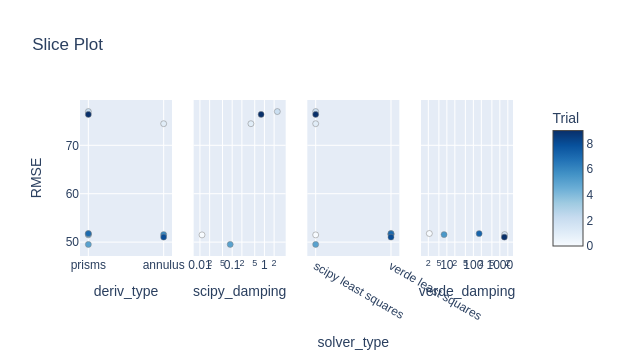

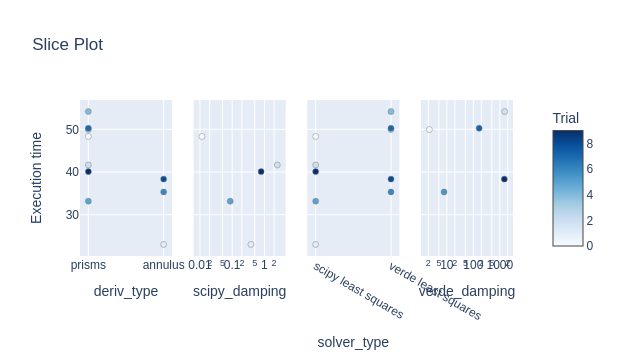

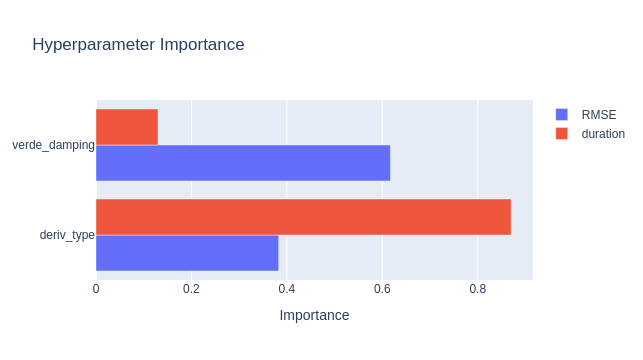

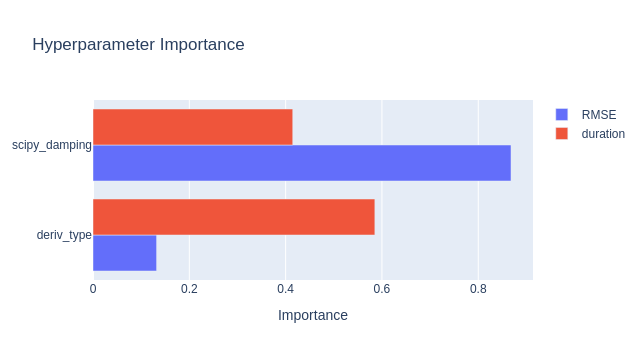

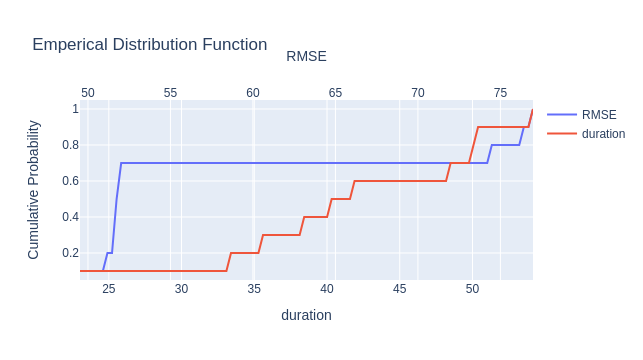

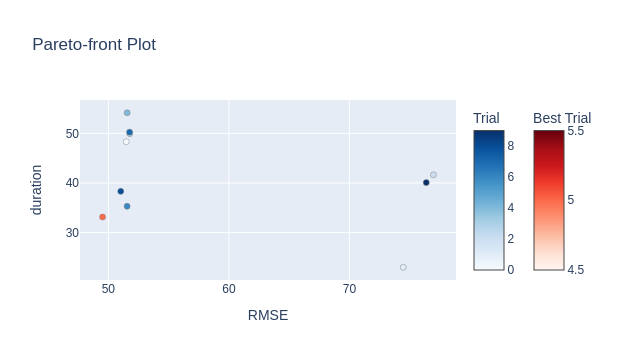

In [154]:
# load and plot past study
study = optuna.load_study(
        study_name=study_name,
        storage=storage,
        )

plots.plot_optuna_inversion_figures(
    study, 
    target_names=objectives,
    include_duration=True,
)

In [157]:
start = study.trials_dataframe().sort_values(by="datetime_start").iloc[0].datetime_start
stop = study.trials_dataframe().sort_values(by="datetime_complete", ascending=False).iloc[0].datetime_complete

time = stop - start
print(f"Total time for optimization: {time.total_seconds()/60} minutes")

Total time for optimization: 0.92685885 minutes


In [158]:
df, best_verde, best_scipy, best_prisms, best_annulus = opti.get_best_of_each_param(study, objectives)
df.sort_values(by=[
    "RMSE", 
    # "constraints", 
    "duration"
    ], inplace=True)
df.head()

best trial w/ solver = verde: index 8
best trial w/ solver = scipy: index 5
best trial w/ deriv = prisms: index 5
best trial w/ deriv = annulus: index 8


number       RMSE             datetime_start          datetime_complete  \
5       5  49.517402 2023-03-06 13:41:20.213828 2023-03-06 13:41:53.363357   
8       8  51.027013 2023-03-06 13:41:19.904252 2023-03-06 13:41:58.232769   
0       0  51.489775 2023-03-06 13:41:18.231351 2023-03-06 13:42:06.559811   
6       6  51.555591 2023-03-06 13:41:20.236285 2023-03-06 13:41:55.551288   
4       4  51.561365 2023-03-06 13:41:19.681856 2023-03-06 13:42:13.842882   

                duration params_deriv_type  params_scipy_damping  \
5 0 days 00:00:33.149529            prisms              0.086896   
8 0 days 00:00:38.328517           annulus                   NaN   
0 0 days 00:00:48.328460            prisms              0.011585   
6 0 days 00:00:35.315003           annulus                   NaN   
4 0 days 00:00:54.161026            prisms                   NaN   

    params_solver_type  params_verde_damping     state  
5  scipy least squares                   NaN  COMPLETE  
8  verde least squares           1475.239130  COMPLETE  
0  scipy least squares                   NaN  COMPLETE  
6  verde least squares              7.828552  COMPLETE  
4  verde least squares           1515.976878  COMPLETE

{'deriv_type': 'prisms', 'solver_type': 'scipy least squares', 'scipy_damping': 0.0868962771341814}
returning original grid
returning original grid
returning original grid
returning original grid
returning original grid
returning original grid
RMSE between surfaces at constraints: 6.14 m


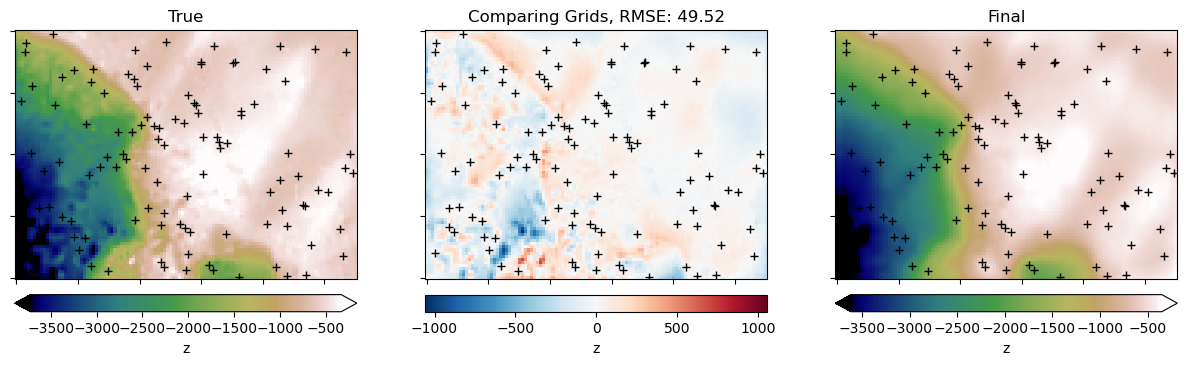

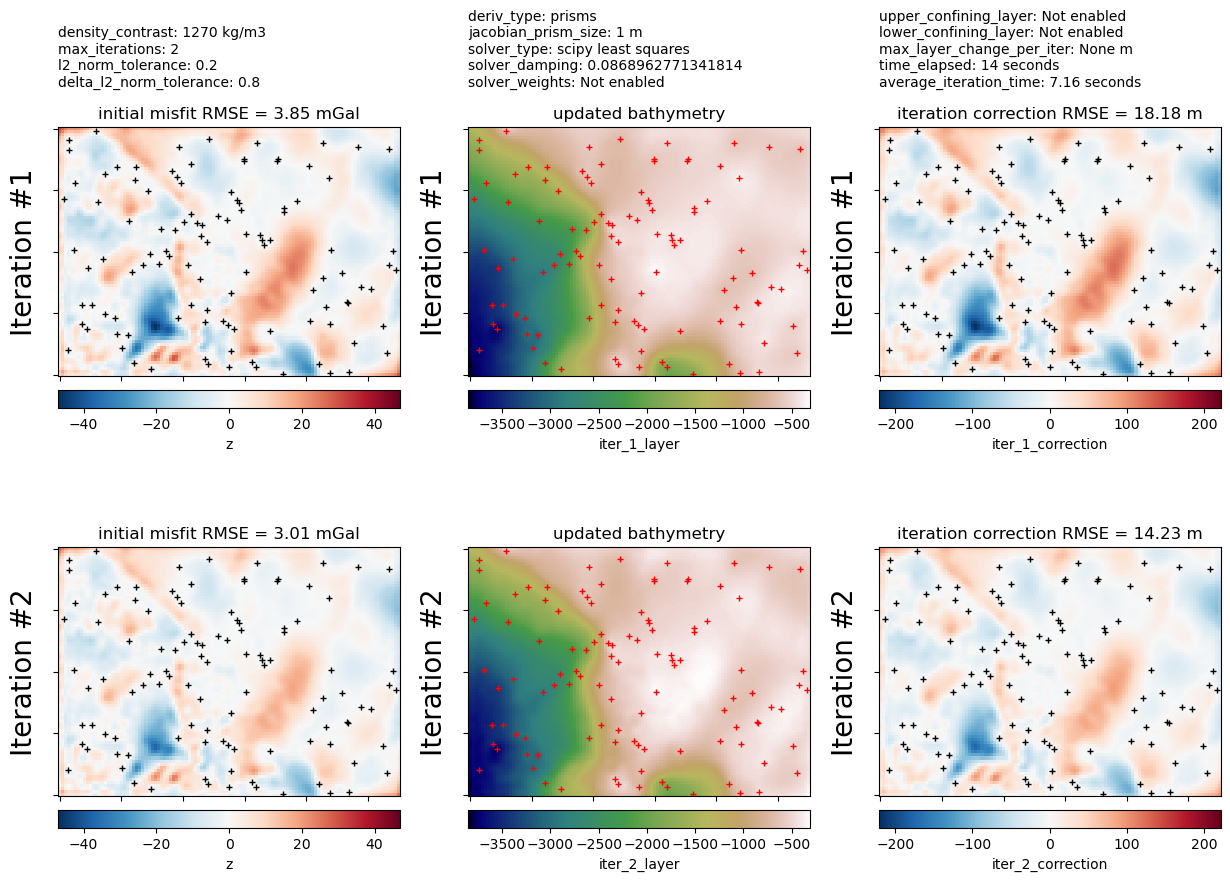

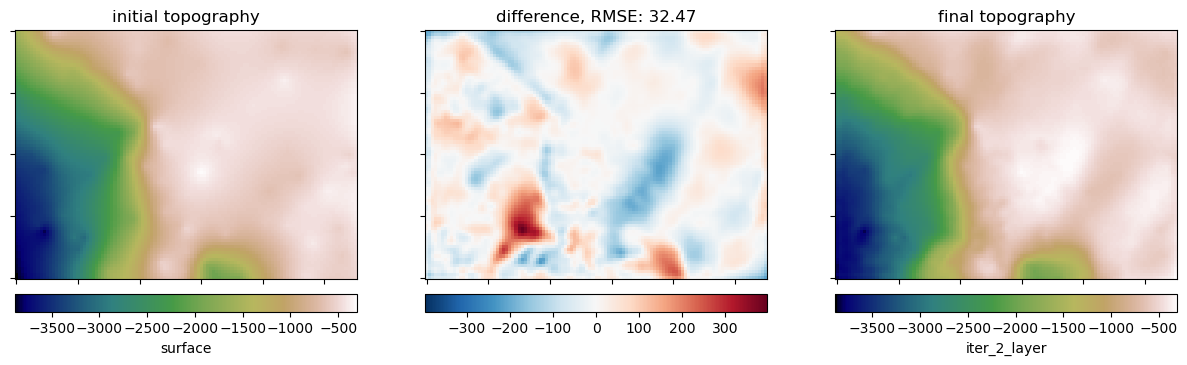

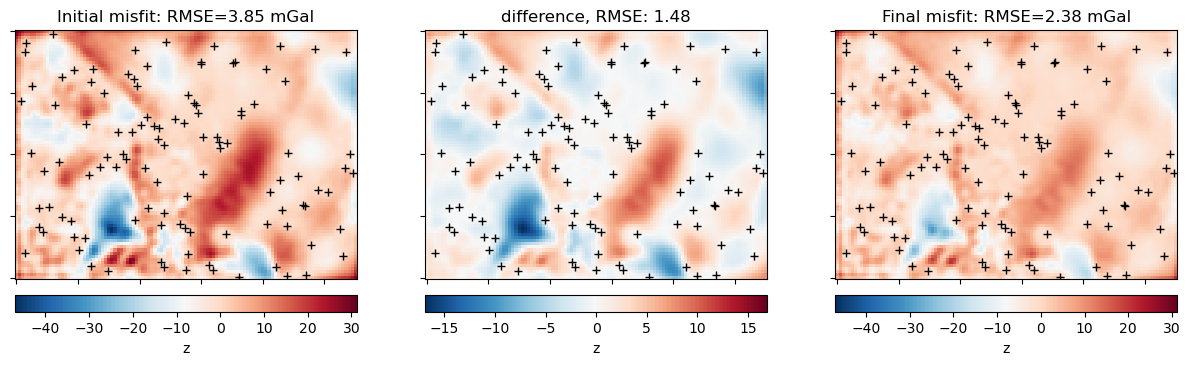

In [159]:
ind = [trial.number for trial in study.trials].index(best_prisms)
best_params = study.trials[ind].params
print(best_params)

plots.plot_best_inversion(
    bed,
    buffer_region,
    best_params=best_params,
    grav_spacing=layer_spacing,
    constraint_points = constraint_points,
    # plot_iter_results = False,
    # plot_topo_results = False,
    # plot_grav_results = False,
    **inversion_kwargs
)

In [160]:
# ind = [trial.number for trial in study.trials].index(best_prisms)
# best_params = study.trials[ind].params
# print(best_params)

# plots.plot_best_inversion(
#     bed,
#     buffer_region,
#     best_params=best_params,
#     grav_spacing=layer_spacing,
#     constraint_points = constraint_points,
#     # plot_iter_results = False,
#     # plot_topo_results = False,
#     # plot_grav_results = False,
#     **inversion_kwargs
# )

# Repeat with simple noise

The above inversion was able to fully recover Layer 2. This is expected, since there was no noise in the data, and we used a very simple 2 layer model to create the observed gravity. Next we add 2% gaussian noise to $G_{misfit}$ to see how the inversion performs.

In [ ]:
df_anomalies_noise = df_anomalies.copy()

df_anomalies_noise['res'] = synth.contaminate(
    df_anomalies_noise.res,
    stddev=0.02,
    percent=True,
    seed=0,
)
df_anomalies_noise

In [ ]:
# set kwargs for inversion
noise_kwargs = dict(
    input_grav = df_anomalies_noise,
    input_grav_column = 'Gobs_corr',
    prism_layer=layer2_prisms,
    max_iterations = 50,
    l2_norm_tolerance = .2,
    delta_l2_norm_tolerance = 0.8,#1.02,
)

In [ ]:
# set name and storage for the optimization
study_name = "2layer_inversion_with_regional_noise_params"
storage = JournalStorage(JournalFileStorage(f"../optimization_logs/{study_name}.log"))

# set number of runs
n_trials=100

# set objectives
objectives = [
    "RMSE"
    # "duration"
    # "constraints"
]

# set directions
directions=[
    "minimize"
    # "minimize" 
    # "minimize"
]

# # create study
# study = optuna.create_study(
#     study_name=study_name,
#     storage=storage,
#     directions=directions,
#     # sampler=optuna.samplers.TPESampler(n_startup_trials=int(n_trials/3)),
#     sampler=optuna.integration.BoTorchSampler(n_startup_trials=int(n_trials/3)),
#     load_if_exists=True,
#     )

# # define the objective function
# objective_func = opti.optimal_inversion_params(
#     true_layer2,
#     verde_damping_limits = [0, 1e4],
#     scipy_damping_limits = [0, 1],
#     objectives = objectives,
#     constraints = constraint_points,
#     **noise_kwargs)

# # run the optimization
# with inv_utils.HiddenPrints():
#     study, study_df = opti.optuna_parallel(
#         study_name=study_name,
#         study_storage=storage,
#         objective = objective_func,
#         n_trials=n_trials,
#         maximize_cpus=True,
#     )

In [ ]:
# load and plot past study
study = optuna.load_study(
        study_name=study_name,
        storage=storage,
        )

plots.plot_optuna_inversion_figures(
    study, 
    target_names=objectives,
    # include_duration=True,
)

In [ ]:
start = study.trials_dataframe().sort_values(by="datetime_start").iloc[0].datetime_start
stop = study.trials_dataframe().sort_values(by="datetime_complete", ascending=False).iloc[0].datetime_complete

time = stop - start
print(f"Total time for optimizaiton: {time.total_seconds()/60} minutes")

In [ ]:
df, best_verde, best_scipy, best_prisms, best_annulus = opti.get_best_of_each_param(study, objectives)
# df.sort_values(by=["RMSE", "constraints", "duration"], inplace=True)
df

In [ ]:
ind = [trial.number for trial in study.trials].index(best_scipy)
best_params = study.trials[ind].params
print(best_params)

plots.plot_best_inversion(
    true_layer2,
    buffer_region,
    best_params=best_params,
    grav_spacing=grav_spacing,
    constraint_points = constraint_points,
    **noise_kwargs
)

In [ ]:
ind = [trial.number for trial in study.trials].index(best_scipy)
best_params = study.trials[ind].params
print(best_params)

plots.plot_best_inversion(
    true_layer2,
    buffer_region,
    best_params=best_params,
    grav_spacing=grav_spacing,
    constraint_points = constraint_points,
    **noise_kwargs
)

# Repeat with airborne survey

## Make new gravity dataframe from eq sources

In [ ]:
# dampings = [0.01, 0.1, 1, 10,]
# depths = [5e3, 10e3, 20e3, 50e3]
dampings = np.logspace(-4, 4, num=10)
depths = np.linspace(1e3, 100e3, 10)

import itertools

parameter_sets = [
    dict(damping=combo[0], depth=combo[1])
    for combo in itertools.product(dampings, depths)
]
print("Number of combinations:", len(parameter_sets))

In [ ]:
eq_grav_grid, eq_grav_df = inv_utils.eq_sources_best(
    parameter_sets, 
    (airborne_survey_grav.x,airborne_survey_grav.y, airborne_survey_grav.z),
    airborne_survey_grav.Gobs, 
    inversion_region, airborne_grav_spacing, grav_observation_height)
grid.plot()

In [ ]:
eq_grav_df = eq_grav_df.rename(columns={"northing":"y", "easting":"x"})
eq_grav_df

## Water gravity

In [ ]:
# calculate gravity of layer1
water_grav_grid, water_grav_df = inv_utils.forward_grav_of_prismlayer(
    [water_prisms],
    eq_grav_df,
    names=['water_prisms'],
    remove_median=True,
    progressbar=True,
    plot=False,
)

eq_grav_df['water_forward'] = water_grav_df.forward_total

# subtract from observed gravity
eq_grav_df['Gobs_corr'] = eq_grav_df['predicted_grav'] - eq_grav_df.water_forward

# center on 0
eq_grav_df['Gobs_corr'] -= eq_grav_df['Gobs_corr'].median()

# grid the results
water_forward = eq_grav_df.set_index(["y", "x"]).to_xarray().water_forward
Gobs_corr = eq_grav_df.set_index(["y", "x"]).to_xarray().Gobs_corr

# center on 0
water_forward -= np.median(water_forward)
Gobs_corr -= np.median(Gobs_corr)
eq_grav_df

# Gravity misfit

The `gravity misfit` is defined as the difference between the observed and predicted gravity:

$G_{misfit} = G_{obs} - G_{forward}$ 

To determine $G_{misfit}$, we need to forward model the gravitational effect of the low-resolution bathymetry density contrast. This will be the input into our inversion.


## Bed gravity

In [ ]:
# calculate gravity of layer1
bed_grav_grid, bed_grav_df = inv_utils.forward_grav_of_prismlayer(
    [bed_prisms],
    eq_grav_df,
    names=['bed_prisms'],
    remove_median=True,
    progressbar=True,
    plot=False,
)

eq_grav_df['bed_forward'] = bed_grav_df.forward_total

# grid the results
bed_forward = eq_grav_df.set_index(["y", "x"]).to_xarray().bed_forward

# center on 0
bed_forward -= np.median(bed_forward)

eq_grav_df

## Save and load results

In [ ]:
eq_grav_df.to_csv(
    "../synthetic_data/Ross_Sea_starting_model_airborne_survey_forward_gravity.csv.gz",
    sep=",",
    na_rep="",
    header=True,
    index=False,
    encoding="utf-8",
    compression="gzip",
) 

In [ ]:
eq_grav_df = pd.read_csv(
    "../synthetic_data/Ross_Sea_starting_model_airborne_survey_forward_gravity.csv.gz",
    sep=",",
    header="infer",
    index_col=None,
    compression="gzip",
)

eq_grav_df

## Regional - Residual seperation

The `corrected observed gravity` is the combination of the signal from the density contrasts of `bathymetry` and `basement`. Both of these signals contain long-wavelength components, since both surface have long-wavelength topographic features. The `bathymetry` signal also contains short-wavelength components. Deeper in the crust, further away from the gravity observation points, these short-wavelength components decrease in amplitude. This means the majority the short-wavelength signal in the `corrected observed gravity` is resulting from the density contrast of the `bathymetry`. This is the signal we want to isolate and input into the inversion. 

To do this, we need to seperate the gravity misfit into a `regional` component and a `residual` component. This `regional` field should theoretically contain every gravity signal other than the that resulting from the `bathymetry` surface. Additionaly, this `residual` component should theoretically represent the gravity anomaly due to the difference between the true `bathymetry` and the low-resolution `bathymetry`. 

If we fail to accurately remove the `regional` signal, the resulting `bathymetry` after the inversion will contain long-wavelength topography, resulting from the `regional` gravity field. 

Since we created the synthetic model, we precisely know the regional component (the forward gravity of the `basement`), and can thus tune our regional-residual seperation method to accurately remove the regional field. 

### optimize the regional-residual seperation

We have 4 methods to seperate the regional misfit from the residual misfit.
1) `Filter` method: Apply a low-pass filter to the misfit
2) `Trend` method: Fit a trend to the misfit
3) `Constraints` method: Sample and grid the misfit only at constraint points, where we know the true layer depth
4) `Equivalent-Sources` method: Predict the gravity anomaly resulting from a serious of deep sources.

Each of these methods has 1 parameter to tune. Respectively, these are 
1) gaussian low-pass filter width (1km - 1000km)
2) trend order (1 - 20)
3) gridding tension factor (0 - 1)
4) source depth (10km - 10,000km)

The optimization will explore the parameter space of each of these, and return the parameters which result in your choice of:
a) a `regional misfit` closest to the true layer 3 forward gravity,
b) the smallest `residuals` at the constraint points

Since we know the true `regional` field, we will use method a). For a true inversion where you don't know the `regional` field, you can use method b). This method finds the seperation method which minimize the `residuals` at contraint points. Since at these contraint points you know the starting layer elevation is accurate, the misfit should be entirely due to the `regional` field, and the `residual` should be close to 0. 

Choose to either run all 4 methods in the same optimization, or run each seperately. 

In [ ]:
regional_kwargs = dict(
    input_grav=eq_grav_df,
    input_forward_column = 'bed_forward',
    input_grav_column = 'Gobs_corr',
    grav_spacing=airborne_grav_spacing,
    inversion_region=inversion_region,
    true_regional=true_regional_grav,
    constraints=constraint_points,
    block_size=airborne_grav_spacing*10,
)

## Optimize all methods individually

In [ ]:
# set comparison method
# comparison_method='minimize_constraints'
comparison_method='regional_comparison'

methods = [
    "filter", 
    "trend", 
    "constraints", 
    "eq_sources"
    ]

# for i in methods:
#     # set name and storage for the optimization
#     study_name = f"Ross_Sea_regional_seperation_indiv_{i}_{comparison_method}"
#     storage = JournalStorage(JournalFileStorage(f"../optimization_logs/{study_name}.log"))

#     # set number of runs
#     n_trials=50

#     # create a new study
#     study = optuna.create_study(
#         study_name=study_name,
#         storage=storage,
#         direction="minimize",
#         # sampler=optuna.samplers.TPESampler(n_startup_trials=int(n_trials/3)),
#         sampler=optuna.integration.BoTorchSampler(n_startup_trials=int(n_trials/3)),
#         load_if_exists=True,
#         )

#     # define the objective function
#     objective = opti.optimal_regional_params(
#         comparison_method = comparison_method,
#         regional_method = i,
#         filter_limits = [10e3, 1000e3, 10e3], # 100 options
#         trend_limits = [1, 20, 1], # 20 options
#         constraints_limits = [0, 1, 0.01], # 101 options
#         eq_sources_limits = [10e3, 10000e3, 10e3], # 1000 options
#         **regional_kwargs)

#     # run the optimization
#     with inv_utils.HiddenPrints():
#         with warnings.catch_warnings():
#             warnings.simplefilter("ignore")
#             study, study_df = opti.optuna_parallel(
#                 study_name=study_name,
#                 study_storage=storage,
#                 objective=objective,
#                 n_trials=n_trials,
#                 maximize_cpus=True,
#             )

In [ ]:
# load studies
study_dfs = []
for i in methods:
    study_name = f"Ross_Sea_regional_seperation_indiv_{i}_{comparison_method}"
    storage = JournalStorage(JournalFileStorage(f"../optimization_logs/{study_name}.log"))
    study = optuna.load_study(storage=storage, study_name=study_name)
    study_df = study.trials_dataframe()
    study_dfs.append(study_df) 
    
    # plot results
    # plots.plot_best_param(
    #     study_df, 
    #     comparison_method, 
    #     regional_method=i, 
    #     **regional_kwargs)
    optuna.visualization.plot_slice(study).show()
    
studies = dict(zip(methods, study_dfs))

for k, v in studies.items():
    v['params_method']=k

regional_sep_combined_studies = pd.concat(studies.values(), ignore_index=True).sort_values(by="value")

In [ ]:
df = regional_sep_combined_studies
df.head()

In [ ]:
best_filter = df[df.params_method == 'filter'].iloc[0].number
best_trend = df[df.params_method == 'trend'].iloc[0].number
best_constraints = df[df.params_method == 'constraints'].iloc[0].number
best_eq_sources = df[df.params_method == 'eq_sources'].iloc[0].number

print(f"best trial w/ method = filter: index {best_filter}")
print(f"best trial w/ method = trend: index {best_trend}")
print(f"best trial w/ method = constraints: index {best_constraints}")
print(f"best trial w/ method = eq. sources: index {best_eq_sources}")

## Best regional seperation

In [ ]:
# choose the regional method:
# regional_method = "filter"
# regional_method = "trend"
regional_method = "constraints"
# regional_method = "eq_sources"
# regional_method = df.params_method.iloc[0]

# set the parameter:
# contraints: 1 results in pedastals, 0 is good,
param = .23 #1000e3

# or use the best parameter from the optimization
# param = df[df[f"params_{regional_method}"].notnull()].iloc[0][f"params_{regional_method}"]

df_anomalies = inv.regional_seperation(
        regional_method=regional_method,
        filter=f"g{param}",
        trend=param,
        tension_factor=param,
        eq_sources=param,
        **regional_kwargs,
    )

anom_grids = plots.anomalies_plotting(
        df_anomalies,
        region=inversion_region,
        grav_spacing=airborne_grav_spacing,
        title=f" Method: {regional_method}, parameter: {param}",
        # constraints=constraint_points,
        input_forward_column = 'bed_forward',
        input_grav_column = 'Gobs_corr',
    )

# Inversion

Now that we have $G_{misfit}$, we can run an inversion to attempt to recover the true Layer 2 topography. 

To determine optimal inversion parameters, we will run an optimization routine which minimizes the root median square error (RMSE) of the ending Surface 2 to the true Surface 2. 

The parameters we will test are:
* Jacobian methods (annulus vs small prisms)
* Solver methods (Scipy lsqr vs Verde lsqr)
* Solver damping
* max prism change per iteration

In [ ]:
# set kwargs for inversion
inversion_kwargs = dict(
    input_grav = df_anomalies,
    input_grav_column = 'Gobs_corr',
    prism_layer=bed_prisms,
    max_iterations = 100,
    l2_norm_tolerance = .2,
    delta_l2_norm_tolerance = .8,
)

In [ ]:
# # %%snakeviz 

# prism_results, grav_results, params, elapsed_time = inv.geo_inversion(
#     **inversion_kwargs,
    
#     deriv_type = "annulus",
#     # deriv_type = "prisms",
    
#     solver_type = "verde least squares",
#     # solver_type = "scipy least squares",
    
#     # solver_damping = 1000000,
#     # solver_damping = 1000000
#         )

In [ ]:
# grids = plots.plot_inversion_results(
#     grav_results,
#     prism_results, 
#     params,
#     grav_region=inversion_region,
#     grav_spacing=layer_spacing,
#     constraints=constraint_points,
#     plot_topo_results=False,
#     plot_grav_results=False,
#     iters_to_plot=4,
#     )

In [ ]:
# set name and storage for the optimization
study_name = "Ross_Sea_inversion_with_regional_airborne_survey_params"
storage = JournalStorage(JournalFileStorage(f"../optimization_logs/{study_name}.log"))

# set number of runs
n_trials=20

# set objectives
objectives = [
    "RMSE"
    # "duration"
    # "constraints"
]

# set directions
directions=[
    "minimize"
    # "minimize" 
    # "minimize"
]

# create study
study = optuna.create_study(
    study_name=study_name,
    storage=storage,
    directions=directions,
    # sampler=optuna.samplers.TPESampler(n_startup_trials=int(n_trials/3)),
    sampler=optuna.integration.BoTorchSampler(n_startup_trials=int(n_trials/3)),
    load_if_exists=True,
    )

# define the objective function
objective_func = opti.optimal_inversion_params(
    lowres_bed,
    verde_damping_limits = [0, 1e4],
    scipy_damping_limits = [0, 1],
    objectives = objectives,
    constraints = constraint_points,
    **inversion_kwargs)

# run the optimization
with inv_utils.HiddenPrints():
    study, study_df = opti.optuna_parallel(
        study_name=study_name,
        study_storage=storage,
        objective = objective_func,
        n_trials=n_trials,
        maximize_cpus=True,
    )

In [ ]:
# load and plot past study
study = optuna.load_study(
        study_name=study_name,
        storage=storage,
        )

plots.plot_optuna_inversion_figures(
    study, 
    target_names=objectives,
    include_duration=True,
)

In [ ]:
start = study.trials_dataframe().sort_values(by="datetime_start").iloc[0].datetime_start
stop = study.trials_dataframe().sort_values(by="datetime_complete", ascending=False).iloc[0].datetime_complete

time = stop - start
print(f"Total time for optimizaiton: {time.total_seconds()/60} minutes")

In [ ]:
df, best_verde, best_scipy, best_prisms, best_annulus = opti.get_best_of_each_param(study, objectives)
# df.sort_values(by=["RMSE", "constraints", "duration"], inplace=True)
df

In [ ]:
ind = [trial.number for trial in study.trials].index(best_annulus)
best_params = study.trials[ind].params
print(best_params)

plots.plot_best_inversion(
    bed,
    buffer_region,
    best_params=best_params,
    grav_spacing=airborne_grav_spacing,
    constraint_points = constraint_points,
    **inversion_kwargs
)

In [ ]:
ind = [trial.number for trial in study.trials].index(best_prisms)
best_params = study.trials[ind].params
print(best_params)

plots.plot_best_inversion(
    bed,
    buffer_region,
    best_params=best_params,
    grav_spacing=airborne_grav_spacing,
    constraint_points = constraint_points,
    **inversion_kwargs
)